In [1]:
%load_ext autoreload
%autoreload 2

from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
import pandas as pd
import sqlite3
import math
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from order_fingers import TouchTracker
import numpy as np
import itertools
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
db_path = "./merged.sqlite"

In [3]:
query = """
WITH data_with_state AS (
    SELECT
        sd.*, 
        rt.title,
        stm.marker AS marker_at_this_timestamp,
        (
            SELECT stm_inner.marker
            FROM sessionTaskMarker stm_inner
            WHERE stm_inner.session_task_id = sd.session_task_id
              AND stm_inner.timestamp <= sd.timestamp
              AND stm_inner.marker IN ('start', 'end')
            ORDER BY stm_inner.timestamp DESC
            LIMIT 1
        ) AS most_recent_marker_type,
        (
            SELECT stm_inner.timestamp
            FROM sessionTaskMarker stm_inner
            WHERE stm_inner.session_task_id = sd.session_task_id
              AND stm_inner.timestamp <= sd.timestamp
              AND stm_inner.marker = 'start'
            ORDER BY stm_inner.timestamp DESC
            LIMIT 1
        ) AS group_start_timestamp
        
    FROM sensorData sd
    LEFT JOIN sessionTaskMarker stm
        ON sd.session_task_id = stm.session_task_id
        AND sd.timestamp = stm.timestamp
    LEFT JOIN sessionTask st
        ON sd.session_task_id = st.id
    LEFT JOIN recordingTask rt
        ON st.recording_task_id = rt.id
)
SELECT 
    group_start_timestamp AS group_id,
    marker_at_this_timestamp AS marker,
    id,
    session_task_id,
    title as gesture,
    timestamp,
    button_pressed,
    motor_angle,
    touch_1_position,
    touch_1_pressure,
    touch_1_channel,
    touch_2_position,
    touch_2_pressure,
    touch_2_channel,
    touch_3_position,
    touch_3_pressure,
    touch_3_channel,
    touch_4_position,
    touch_4_pressure,
    touch_4_channel,
    touch_5_position,
    touch_5_pressure,
    touch_5_channel
FROM data_with_state dws
WHERE
    most_recent_marker_type = 'start'
    OR marker_at_this_timestamp = 'end';
"""

with sqlite3.connect(db_path) as conn:
    # Use pandas to execute the query and load results into a DataFrame
    df = pd.read_sql_query(query, conn)

df.head()

group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

             timestamp  button_pressed  motor_angle  touch_1_position  \
0  2025-10-03 15:35:06               0    -2.076243               NaN   
1  2025-10-03 15:35:06               0    -2.075093               NaN   
2  2025-10-03 15:35:06               0    -2.074709               NaN   
3  2025-10-03 15:35:06               0    -2.074709               NaN   
4  2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_2_channel  touch_3_position  touch_3_pressure  \
0               NaN  ...              NaN               NaN               NaN   
1               NaN  ...              NaN               NaN               NaN   
2               NaN  ...              NaN               NaN               NaN   
3               NaN  ...              NaN               NaN               NaN   
4               NaN  ...              NaN               NaN               NaN   

   touch_3_channel  touch_4_position  touch_4_pressure  touch_4_channel  \
0              NaN               NaN               NaN              NaN   
1              NaN               NaN               NaN              NaN   
2              NaN               NaN               NaN              NaN   
3              NaN               NaN               NaN              NaN   
4              NaN               NaN               NaN              NaN   

   touch_5_position  touch_5_pressure  touch_5_channel  
0               NaN               NaN              NaN  
1               NaN               NaN              NaN  
2               NaN               NaN              NaN  
3               NaN               NaN              NaN  
4               NaN               NaN              NaN  

[5 rows x 23 columns]

In [4]:
# timestamp from datetime string to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

group_id                    object
marker                      object
id                          object
session_task_id             object
gesture                     object
timestamp           datetime64[ns]
button_pressed               int64
motor_angle                float64
touch_1_position           float64
touch_1_pressure           float64
touch_1_channel            float64
touch_2_position           float64
touch_2_pressure           float64
touch_2_channel            float64
touch_3_position           float64
touch_3_pressure           float64
touch_3_channel            float64
touch_4_position           float64
touch_4_pressure           float64
touch_4_channel            float64
touch_5_position           float64
touch_5_pressure           float64
touch_5_channel            float64
dtype: object

In [5]:
# since the timestamp currently only has a resolution of 1s, we need to calculate an estimate of the real timestamp by adding fractions of a second based on the row order within each session_task_id, where the time interval changes based on the number of recordings within a given second
# df = df.sort_values(by=['session_task_id', 'timestamp', 'id']).reset_index(drop=True)
df['time_diff'] = df.groupby(['session_task_id', 'timestamp']).cumcount()
df['recordings_per_second'] = df.groupby(['session_task_id', 'timestamp'])['id'].transform('count')
df['estimated_timestamp'] = df['timestamp'] + pd.to_timedelta(df['time_diff'] / df['recordings_per_second'], unit='s')
df = df.drop(columns=['time_diff', 'recordings_per_second'])
# df = df.sort_values(by=['session_task_id', 'estimated_timestamp']).reset_index(drop=True)

df["timestamp_ms"] = (df["estimated_timestamp"].astype(np.int64) // 10**6).astype(np.int64)

df.head()

group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

            timestamp  button_pressed  motor_angle  touch_1_position  \
0 2025-10-03 15:35:06               0    -2.076243               NaN   
1 2025-10-03 15:35:06               0    -2.075093               NaN   
2 2025-10-03 15:35:06               0    -2.074709               NaN   
3 2025-10-03 15:35:06               0    -2.074709               NaN   
4 2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_3_pressure  touch_3_channel  touch_4_position  \
0               NaN  ...               NaN              NaN               NaN   
1               NaN  ...               NaN              NaN               NaN   
2               NaN  ...               NaN              NaN               NaN   
3               NaN  ...               NaN              NaN               NaN   
4               NaN  ...               NaN              NaN               NaN   

   touch_4_pressure  touch_4_channel  touch_5_position  touch_5_pressure  \
0               NaN              NaN               NaN               NaN   
1               NaN              NaN               NaN               NaN   
2               NaN              NaN               NaN               NaN   
3               NaN              NaN               NaN               NaN   
4               NaN              NaN               NaN               NaN   

   touch_5_channel           estimated_timestamp   timestamp_ms  
0              NaN 2025-10-03 15:35:06.000000000  1759505706000  
1              NaN 2025-10-03 15:35:06.007874015  1759505706007  
2              NaN 2025-10-03 15:35:06.015748031  1759505706015  
3              NaN 2025-10-03 15:35:06.023622047  1759505706023  
4              NaN 2025-10-03 15:35:06.031496062  1759505706031  

[5 rows x 25 columns]

In [6]:
# print unique gestures
df['gesture'].unique()

array(['Pinch Swipe (Links)', 'Pinch Swipe (Rechts)',
       'Double Tap (4 Finger)', 'Double Tap (3 Finger, Luft)',
       'Two-Finger Opposite Tap (All Air)',
       'Two-Finger Opposite Tap (4 Finger)',
       'Two-Finger Opposite Double Tap (All Air)',
       'Two-Finger Opposite Double Tap (4 Finger)',
       'Single Tap (3 Finger, Luft)', 'Single Tap (4 Finger)',
       'Knob Turn (3 Fingers)', 'Knob Turn (All Fingers)',
       'Knob Press (No Fingers)', 'Knob Press (4 Fingers)',
       'Lay On (2 Fingers)', 'Lay On (3 Fingers)',
       'Tap and Hold (2 Finger)', 'Tap and Hold (3 Finger)',
       'Spread Swipe (Links)', 'Spread Swipe (Rechts)',
       'Two-Finger Double Tap (4 Finger)',
       'Two-Finger Double Tap (3 Finger)', 'Single Swipe (All Air)',
       'Single Swipe (3 Finger)', 'Two-Finger Tap (4 Finger)',
       'Two-Finger Tap (3 Finger)', 'Musik Vorschau', 'Dateien kopieren',
       'Bild vergrößern'], dtype=object)

In [7]:
# Normalize the pressure per session_task
df['touch_1_pressure_norm'] = df.groupby('session_task_id')['touch_1_pressure']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['touch_2_pressure_norm'] = df.groupby('session_task_id')['touch_2_pressure']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['touch_3_pressure_norm'] = df.groupby('session_task_id')['touch_3_pressure']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['touch_4_pressure_norm'] = df.groupby('session_task_id')['touch_4_pressure']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['touch_5_pressure_norm'] = df.groupby('session_task_id')['touch_5_pressure']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [8]:
# Add angular velocity for app touches based on their position
def compute_angular_velocity(positions, timestamps):
    velocities = [0]  # First velocity is zero
    for i in range(1, len(positions)):
        pos_diff = positions[i] - positions[i - 1]
        time_diff = (timestamps[i] - timestamps[i - 1]) / 1000.0  # Convert ms to s
        if time_diff > 0:
            velocity = pos_diff / time_diff
        else:
            velocity = 0
        velocities.append(velocity)
    return velocities
df['touch_1_angular_velocity'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_velocity(group['touch_1_position'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_2_angular_velocity'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_velocity(group['touch_2_position'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_3_angular_velocity'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_velocity(group['touch_3_position'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_4_angular_velocity'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_velocity(group['touch_4_position'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_5_angular_velocity'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_velocity(group['touch_5_position'].values, group['timestamp_ms'].values)
).explode().astype(float).values

df.head()

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\2463801801.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['touch_1_angular_velocity'] = df.groupby('session_task_id').apply(
C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\2463801801.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['touch_2_angular_velocity'] = df.groupby('session_task_id').apply(
C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\24

group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

            timestamp  button_pressed  motor_angle  touch_1_position  \
0 2025-10-03 15:35:06               0    -2.076243               NaN   
1 2025-10-03 15:35:06               0    -2.075093               NaN   
2 2025-10-03 15:35:06               0    -2.074709               NaN   
3 2025-10-03 15:35:06               0    -2.074709               NaN   
4 2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_1_pressure_norm  touch_2_pressure_norm  \
0               NaN  ...                    NaN                    NaN   
1               NaN  ...                    NaN                    NaN   
2               NaN  ...                    NaN                    NaN   
3               NaN  ...                    NaN                    NaN   
4               NaN  ...                    NaN                    NaN   

   touch_3_pressure_norm  touch_4_pressure_norm  touch_5_pressure_norm  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   touch_1_angular_velocity  touch_2_angular_velocity  \
0                  0.000000                       0.0   
1                  0.015107                       NaN   
2                 -0.000491                       NaN   
3                 -0.021909                       NaN   
4                  0.030449                       NaN   

   touch_3_angular_velocity  touch_4_angular_velocity  \
0                       0.0                       0.0   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   touch_5_angular_velocity  
0                       0.0  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 35 columns]

In [9]:
# compute angular acceleration for app touches based on their angular velocity
def compute_angular_acceleration(velocities, timestamps):
    accelerations = [0]  # First acceleration is zero
    for i in range(1, len(velocities)):
        vel_diff = velocities[i] - velocities[i - 1]
        time_diff = (timestamps[i] - timestamps[i - 1]) / 1000.0  # Convert ms to s
        if time_diff > 0:
            acceleration = vel_diff / time_diff
        else:
            acceleration = 0
        accelerations.append(acceleration)
    return accelerations
df['touch_1_angular_acceleration'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_acceleration(group['touch_1_angular_velocity'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_2_angular_acceleration'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_acceleration(group['touch_2_angular_velocity'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_3_angular_acceleration'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_acceleration(group['touch_3_angular_velocity'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_4_angular_acceleration'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_acceleration(group['touch_4_angular_velocity'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df['touch_5_angular_acceleration'] = df.groupby('session_task_id').apply(
    lambda group: compute_angular_acceleration(group['touch_5_angular_velocity'].values, group['timestamp_ms'].values)
).explode().astype(float).values
df.head()

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\3353222992.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['touch_1_angular_acceleration'] = df.groupby('session_task_id').apply(
C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\3353222992.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['touch_2_angular_acceleration'] = df.groupby('session_task_id').apply(
C:\Users\joshu\AppData\Local\Temp\ipykernel_

group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

            timestamp  button_pressed  motor_angle  touch_1_position  \
0 2025-10-03 15:35:06               0    -2.076243               NaN   
1 2025-10-03 15:35:06               0    -2.075093               NaN   
2 2025-10-03 15:35:06               0    -2.074709               NaN   
3 2025-10-03 15:35:06               0    -2.074709               NaN   
4 2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_1_angular_velocity  touch_2_angular_velocity  \
0               NaN  ...                  0.000000                       0.0   
1               NaN  ...                  0.015107                       NaN   
2               NaN  ...                 -0.000491                       NaN   
3               NaN  ...                 -0.021909                       NaN   
4               NaN  ...                  0.030449                       NaN   

   touch_3_angular_velocity  touch_4_angular_velocity  \
0                       0.0                       0.0   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   touch_5_angular_velocity  touch_1_angular_acceleration  \
0                       0.0                      0.000000   
1                       NaN                     17.869402   
2                       NaN                    -20.805573   
3                       NaN                   -138.397375   
4                       NaN                     42.114385   

   touch_2_angular_acceleration  touch_3_angular_acceleration  \
0                      0.000000                           0.0   
1                     86.691253                           NaN   
2                   -232.122958                           NaN   
3                    183.321920                           NaN   
4                   -223.786168                           NaN   

   touch_4_angular_acceleration  touch_5_angular_acceleration  
0                           0.0                           0.0  
1                           NaN                           NaN  
2                           NaN                           NaN  
3                           NaN                           NaN  
4                           NaN                           NaN  

[5 rows x 40 columns]

In [10]:
# set velocity and acceleration to zero if it is nan
df['touch_1_angular_velocity'] = df['touch_1_angular_velocity'].fillna(0)
df['touch_2_angular_velocity'] = df['touch_2_angular_velocity'].fillna(0)
df['touch_3_angular_velocity'] = df['touch_3_angular_velocity'].fillna(0)
df['touch_4_angular_velocity'] = df['touch_4_angular_velocity'].fillna(0)
df['touch_5_angular_velocity'] = df['touch_5_angular_velocity'].fillna(0)
df['touch_1_angular_acceleration'] = df['touch_1_angular_acceleration'].fillna(0)
df['touch_2_angular_acceleration'] = df['touch_2_angular_acceleration'].fillna(0)
df['touch_3_angular_acceleration'] = df['touch_3_angular_acceleration'].fillna(0)
df['touch_4_angular_acceleration'] = df['touch_4_angular_acceleration'].fillna(0)
df['touch_5_angular_acceleration'] = df['touch_5_angular_acceleration'].fillna(0)

In [11]:
# add a normalized position, where the position of the first touch is the zero point, so all positions have to be shifted accordingly
touch_cols = [f"touch_{i}_position" for i in range(1, 6)]
norm_cols = [f"{c}_norm" for c in touch_cols]

def normalize_group(g):
    # Convert group slice to numpy array (rows in original order, columns as listed)
    arr = g[touch_cols].to_numpy(dtype=float)   # shape (n_rows, 5)
    # Flatten row-major and find first non-NaN
    flat = arr.ravel(order='C')                 # row 0: touch_1..touch_5, then next row...
    # boolean mask
    nonnan_idx = np.where(~np.isnan(flat))[0]
    if nonnan_idx.size == 0:
        # no valid zero point: keep normalized columns as NaN (or copy original if you prefer)
        for c_norm in norm_cols:
            g[c_norm] = np.nan
        # Optionally: return g.assign(**{c_norm: g[c] for c_norm, c in zip(norm_cols, touch_cols)})
        return g
    # first non-NaN scalar
    first_val = flat[nonnan_idx[0]]
    # subtract scalar from every touch column in the group
    for c, c_norm in zip(touch_cols, norm_cols):
        g[c_norm] = g[c] - first_val
    return g

# Apply per-group
df = df.groupby('session_task_id', group_keys=False).apply(normalize_group)
df.head()

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\3494095652.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('session_task_id', group_keys=False).apply(normalize_group)


group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

            timestamp  button_pressed  motor_angle  touch_1_position  \
0 2025-10-03 15:35:06               0    -2.076243               NaN   
1 2025-10-03 15:35:06               0    -2.075093               NaN   
2 2025-10-03 15:35:06               0    -2.074709               NaN   
3 2025-10-03 15:35:06               0    -2.074709               NaN   
4 2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_1_angular_acceleration  \
0               NaN  ...                      0.000000   
1               NaN  ...                     17.869402   
2               NaN  ...                    -20.805573   
3               NaN  ...                   -138.397375   
4               NaN  ...                     42.114385   

   touch_2_angular_acceleration  touch_3_angular_acceleration  \
0                      0.000000                           0.0   
1                     86.691253                           0.0   
2                   -232.122958                           0.0   
3                    183.321920                           0.0   
4                   -223.786168                           0.0   

   touch_4_angular_acceleration  touch_5_angular_acceleration  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   touch_1_position_norm  touch_2_position_norm  touch_3_position_norm  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   touch_4_position_norm  touch_5_position_norm  
0                    NaN                    NaN  
1                    NaN                    NaN  
2                    NaN                    NaN  
3                    NaN                    NaN  
4                    NaN                    NaN  

[5 rows x 45 columns]

In [12]:
df[["touch_1_position", "touch_1_position_norm"]].describe()

touch_1_position  touch_1_position_norm
count     118631.000000          118631.000000
mean           2.031485               0.116458
std            1.353820               1.596042
min            0.001231              -6.178466
25%            0.834827              -0.073674
50%            1.887009               0.001395
75%            2.916547               0.408544
max            6.282824               6.278797

In [13]:
# for each finger, get the shortest distance to each other finger (wrap around 2PI and 0 if that is shorter)
def min_angular_distance(angle1, angle2):
    diff = abs(angle1 - angle2) % (2 * math.pi)
    return min(diff, 2 * math.pi - diff)
df['touch_1_to_2_distance'] = df.apply(lambda row: min_angular_distance(row['touch_1_position'], row['touch_2_position']), axis=1)
df['touch_1_to_3_distance'] = df.apply(lambda row: min_angular_distance(row['touch_1_position'], row['touch_3_position']), axis=1)
df['touch_1_to_4_distance'] = df.apply(lambda row: min_angular_distance(row['touch_1_position'], row['touch_4_position']), axis=1)
df['touch_1_to_5_distance'] = df.apply(lambda row: min_angular_distance(row['touch_1_position'], row['touch_5_position']), axis=1)
df['touch_2_to_3_distance'] = df.apply(lambda row: min_angular_distance(row['touch_2_position'], row['touch_3_position']), axis=1)
df['touch_2_to_4_distance'] = df.apply(lambda row: min_angular_distance(row['touch_2_position'], row['touch_4_position']), axis=1)
df['touch_2_to_5_distance'] = df.apply(lambda row: min_angular_distance(row['touch_2_position'], row['touch_5_position']), axis=1)
df['touch_3_to_4_distance'] = df.apply(lambda row: min_angular_distance(row['touch_3_position'], row['touch_4_position']), axis=1)
df['touch_3_to_5_distance'] = df.apply(lambda row: min_angular_distance(row['touch_3_position'], row['touch_5_position']), axis=1)
df['touch_4_to_5_distance'] = df.apply(lambda row: min_angular_distance(row['touch_4_position'], row['touch_5_position']), axis=1)
df.head()

group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

            timestamp  button_pressed  motor_angle  touch_1_position  \
0 2025-10-03 15:35:06               0    -2.076243               NaN   
1 2025-10-03 15:35:06               0    -2.075093               NaN   
2 2025-10-03 15:35:06               0    -2.074709               NaN   
3 2025-10-03 15:35:06               0    -2.074709               NaN   
4 2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_1_to_2_distance  touch_1_to_3_distance  \
0               NaN  ...                    NaN                    NaN   
1               NaN  ...                    NaN                    NaN   
2               NaN  ...                    NaN                    NaN   
3               NaN  ...                    NaN                    NaN   
4               NaN  ...                    NaN                    NaN   

   touch_1_to_4_distance  touch_1_to_5_distance  touch_2_to_3_distance  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   touch_2_to_4_distance  touch_2_to_5_distance  touch_3_to_4_distance  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   touch_3_to_5_distance  touch_4_to_5_distance  
0                    NaN                    NaN  
1                    NaN                    NaN  
2                    NaN                    NaN  
3                    NaN                    NaN  
4                    NaN                    NaN  

[5 rows x 55 columns]

In [14]:
# set nan distances to 2PI (maximum distance)
df['touch_1_to_2_distance'] = df['touch_1_to_2_distance'].fillna(0)
df['touch_1_to_3_distance'] = df['touch_1_to_3_distance'].fillna(0)
df['touch_1_to_4_distance'] = df['touch_1_to_4_distance'].fillna(0)
df['touch_1_to_5_distance'] = df['touch_1_to_5_distance'].fillna(0)
df['touch_2_to_3_distance'] = df['touch_2_to_3_distance'].fillna(0)
df['touch_2_to_4_distance'] = df['touch_2_to_4_distance'].fillna(0)
df['touch_2_to_5_distance'] = df['touch_2_to_5_distance'].fillna(0)
df['touch_3_to_4_distance'] = df['touch_3_to_4_distance'].fillna(0)
df['touch_3_to_5_distance'] = df['touch_3_to_5_distance'].fillna(0)
df['touch_4_to_5_distance'] = df['touch_4_to_5_distance'].fillna(0)
df.head()

group_id marker                                    id  \
0  2025-10-03 15:35:06  start  8efa8c1a-7024-45dd-8972-10db51ae87c4   
1  2025-10-03 15:35:06  start  65cbd4ec-66ed-405a-884f-74227b53d06b   
2  2025-10-03 15:35:06  start  6649c977-3dfa-43f1-837f-bc5ec47b395a   
3  2025-10-03 15:35:06  start  1b191e66-f4f2-4efe-92c1-c6d5fefb30e5   
4  2025-10-03 15:35:06  start  b20fd9bc-c94e-4536-9f66-6dd330b3dd46   

                        session_task_id              gesture  \
0  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
1  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
2  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
3  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   
4  c9168e6c-5bfc-43fc-a6dc-8621e72c32de  Pinch Swipe (Links)   

            timestamp  button_pressed  motor_angle  touch_1_position  \
0 2025-10-03 15:35:06               0    -2.076243               NaN   
1 2025-10-03 15:35:06               0    -2.075093               NaN   
2 2025-10-03 15:35:06               0    -2.074709               NaN   
3 2025-10-03 15:35:06               0    -2.074709               NaN   
4 2025-10-03 15:35:06               0    -2.075476               NaN   

   touch_1_pressure  ...  touch_1_to_2_distance  touch_1_to_3_distance  \
0               NaN  ...                    0.0                    0.0   
1               NaN  ...                    0.0                    0.0   
2               NaN  ...                    0.0                    0.0   
3               NaN  ...                    0.0                    0.0   
4               NaN  ...                    0.0                    0.0   

   touch_1_to_4_distance  touch_1_to_5_distance  touch_2_to_3_distance  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   touch_2_to_4_distance  touch_2_to_5_distance  touch_3_to_4_distance  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   touch_3_to_5_distance  touch_4_to_5_distance  
0                    0.0                    0.0  
1                    0.0                    0.0  
2                    0.0                    0.0  
3                    0.0                    0.0  
4                    0.0                    0.0  

[5 rows x 55 columns]

In [15]:
# Get touch_X_position and touch_X_pressure as a list of list of tuples, so [(touch_1_position, touch_1_pressure), (touch_2_position, touch_2_pressure), ...]
touch_data = []
for idx in range(1,6):
    touch_data.append(list(zip(
        df[f'touch_{idx}_position'], 
        df[f'touch_{idx}_pressure'], 
        df[f'id'], 
        df[f'touch_{idx}_channel'], 
        df[f'touch_{idx}_position_norm'], 
        df[f'touch_{idx}_pressure_norm'], 
        df[f'touch_{idx}_angular_velocity'], 
        df[f'touch_{idx}_angular_acceleration'], 
        df['session_task_id'], 
        df['group_id'], 
        df['motor_angle'], 
        df['button_pressed'], 
        df['gesture'], 
        df['timestamp_ms'],
        df['touch_1_to_2_distance'],
        df['touch_1_to_3_distance'],
        df['touch_1_to_4_distance'],
        df['touch_1_to_5_distance'],
        df['touch_2_to_3_distance'],
        df['touch_2_to_4_distance'],
        df['touch_2_to_5_distance'],
        df['touch_3_to_4_distance'],
        df['touch_3_to_5_distance'],
        df['touch_4_to_5_distance'],
    )))
# touch_data is now a list of 4 lists (one for each touch point), they have to be transposed to get a list of tuples
touch_data = list(zip(*touch_data))

# set all None values to nan
touch_data = [[(pos if pos is not None else np.nan, pres if pres is not None else np.nan, *rest) for pos, pres, *rest in entry] for entry in touch_data]

print(touch_data[:5])  # Print first 5 entries to verify

[[(nan, nan, '8efa8c1a-7024-45dd-8972-10db51ae87c4', nan, nan, nan, 0.0, 0.0, 'c9168e6c-5bfc-43fc-a6dc-8621e72c32de', '2025-10-03 15:35:06', -2.0762431621551514, 0, 'Pinch Swipe (Links)', 1759505706000, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (nan, nan, '8efa8c1a-7024-45dd-8972-10db51ae87c4', nan, nan, nan, 0.0, 0.0, 'c9168e6c-5bfc-43fc-a6dc-8621e72c32de', '2025-10-03 15:35:06', -2.0762431621551514, 0, 'Pinch Swipe (Links)', 1759505706000, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (nan, nan, '8efa8c1a-7024-45dd-8972-10db51ae87c4', nan, nan, nan, 0.0, 0.0, 'c9168e6c-5bfc-43fc-a6dc-8621e72c32de', '2025-10-03 15:35:06', -2.0762431621551514, 0, 'Pinch Swipe (Links)', 1759505706000, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (nan, nan, '8efa8c1a-7024-45dd-8972-10db51ae87c4', nan, nan, nan, 0.0, 0.0, 'c9168e6c-5bfc-43fc-a6dc-8621e72c32de', '2025-10-03 15:35:06', -2.0762431621551514, 0, 'Pinch Swipe (Links)', 1759505706000, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [16]:
tracker = TouchTracker()

iteration = 0

current_group_id = None
tracked = [tracker.assign_ids(row) for row in touch_data]

# Print all unique ids assigned (the first index)
unique_ids = set()
for row in tracked:
    for touch in row:
        unique_ids.add(touch[0])
print("Unique IDs assigned:", len(unique_ids))
df['gesture'].unique()

Unique IDs assigned: 3554


array(['Pinch Swipe (Links)', 'Pinch Swipe (Rechts)',
       'Double Tap (4 Finger)', 'Double Tap (3 Finger, Luft)',
       'Two-Finger Opposite Tap (All Air)',
       'Two-Finger Opposite Tap (4 Finger)',
       'Two-Finger Opposite Double Tap (All Air)',
       'Two-Finger Opposite Double Tap (4 Finger)',
       'Single Tap (3 Finger, Luft)', 'Single Tap (4 Finger)',
       'Knob Turn (3 Fingers)', 'Knob Turn (All Fingers)',
       'Knob Press (No Fingers)', 'Knob Press (4 Fingers)',
       'Lay On (2 Fingers)', 'Lay On (3 Fingers)',
       'Tap and Hold (2 Finger)', 'Tap and Hold (3 Finger)',
       'Spread Swipe (Links)', 'Spread Swipe (Rechts)',
       'Two-Finger Double Tap (4 Finger)',
       'Two-Finger Double Tap (3 Finger)', 'Single Swipe (All Air)',
       'Single Swipe (3 Finger)', 'Two-Finger Tap (4 Finger)',
       'Two-Finger Tap (3 Finger)', 'Musik Vorschau', 'Dateien kopieren',
       'Bild vergrößern'], dtype=object)

In [17]:
# print the first row in tracked that is not an empty array
for i, row in enumerate(tracked):
    if len(row) > 4:
        print("First non-empty tracked row:", row, "at index", i)
        break

First non-empty tracked row: [(286, 1.25031578540802, 439.0, '8718fce9-a022-4877-af3a-aaad8bfe4b81', 2.0, -4.633625864982605, 0.2777390090718772, 0.0, 5.382653716560844, 'c74861aa-fa40-4973-829c-a8403953060d', '2025-10-03 15:45:51', 48.715396881103516, 0, 'Knob Turn (All Fingers)', 1759506351746, 2.019839882850647, 2.4760417381869715, 1.6599687973605555, 1.0405606776475906, 1.7873036861419678, 2.603376626968384, 3.0604005604982376, 0.816072940826416, 1.4354810605393808, 0.6194081197129648), (285, 3.270155668258667, 661.0, '8718fce9-a022-4877-af3a-aaad8bfe4b81', 3.0, -2.613785982131958, 0.39615384615384613, 0.0, 1.9520173817525655, 'c74861aa-fa40-4973-829c-a8403953060d', '2025-10-03 15:45:51', 48.715396881103516, 0, 'Knob Turn (All Fingers)', 1759506351746, 2.019839882850647, 2.4760417381869715, 1.6599687973605555, 1.0405606776475906, 1.7873036861419678, 2.603376626968384, 3.0604005604982376, 0.816072940826416, 1.4354810605393808, 0.6194081197129648), (283, 5.057459354400635, 415.0, '87

In [18]:
import time
import pandas as pd
from collections import defaultdict

# Safe pre-indexing (handles duplicate ids)
df_lookup = (
    df.drop_duplicates(subset='id', keep='first')
      .set_index('id')
      .to_dict(orient='index')
)

rows = []
start_time = time.time()
total = len(touch_data)

for iteration, (row, tracked_row) in enumerate(zip(touch_data, tracked), start=1):
    if iteration % 40 == 0 or iteration == 1:
        elapsed = time.time() - start_time
        avg_time = elapsed / iteration
        remaining = avg_time * (total - iteration)
        print(f"Processing row {iteration}/{total} "
              f"({(iteration/total)*100:.2f}%) | "
              f"Avg: {avg_time:.3f}s | ETA: {remaining/60:.1f} min")

    rows.extend({
        'timestamp': timestamp,
        'position': pos,
        'pressure': pres,
        'channel': channel,
        'position_norm': pos_norm,
        'pressure_norm': pres_norm,
        'angular_velocity': angular_velocity,
        'angular_acceleration': angular_acceleration,
        'gesture': gesture,
        'motor_angle': motor_angle,
        'button_pressed': pressed,
        'touch_id': assigned_id,
        'group_id': group_id,
        'session_task_id': session_task_id,
        'distance_0': dist_0,
        'distance_1': dist_1,
        'distance_2': dist_2,
        'distance_3': dist_3,
        'distance_4': dist_4,
        'distance_5': dist_5,
        'distance_6': dist_6,
        'distance_7': dist_7,
        'distance_8': dist_8,
        'distance_9': dist_9,
    } for (pos, pres, _id, channel, pos_norm, pres_norm, angular_velocity, angular_acceleration, session_task_id, group_id, motor_angle, pressed, gesture, timestamp, dist_0, dist_1, dist_2, dist_3, dist_4, dist_5, dist_6, dist_7, dist_8, dist_9), (assigned_id, *rest_tracked) in zip(row, tracked_row))

grouped_df = pd.DataFrame(rows)
total_time = time.time() - start_time
print(f"\nFinished processing {total} rows in {total_time/60:.1f} minutes.")


Processing row 1/182784 (0.00%) | Avg: 0.000s | ETA: 0.0 min
Processing row 40/182784 (0.02%) | Avg: 0.000s | ETA: 0.0 min
Processing row 80/182784 (0.04%) | Avg: 0.000s | ETA: 0.0 min
Processing row 120/182784 (0.07%) | Avg: 0.000s | ETA: 0.0 min
Processing row 160/182784 (0.09%) | Avg: 0.000s | ETA: 0.0 min
Processing row 200/182784 (0.11%) | Avg: 0.000s | ETA: 0.0 min
Processing row 240/182784 (0.13%) | Avg: 0.000s | ETA: 0.0 min
Processing row 280/182784 (0.15%) | Avg: 0.000s | ETA: 0.0 min
Processing row 320/182784 (0.18%) | Avg: 0.000s | ETA: 0.0 min
Processing row 360/182784 (0.20%) | Avg: 0.000s | ETA: 0.0 min
Processing row 400/182784 (0.22%) | Avg: 0.000s | ETA: 0.0 min
Processing row 440/182784 (0.24%) | Avg: 0.000s | ETA: 0.0 min
Processing row 480/182784 (0.26%) | Avg: 0.000s | ETA: 0.0 min
Processing row 520/182784 (0.28%) | Avg: 0.000s | ETA: 0.0 min
Processing row 560/182784 (0.31%) | Avg: 0.000s | ETA: 0.0 min
Processing row 600/182784 (0.33%) | Avg: 0.000s | ETA: 0.0 

In [19]:
grouped_df.head()

timestamp  position  pressure  channel  position_norm  pressure_norm  \
0  1759505707469  6.230826      49.0      1.0       0.000000       0.005025   
1  1759505707481  6.230826      62.0      1.0       0.000000       0.018090   
2  1759505707493  6.192106     119.0      2.0      -0.038720       0.075377   
3  1759505707506  6.188240     150.0      2.0      -0.042586       0.106533   
4  1759505707518  6.186911     186.0      2.0      -0.043915       0.142714   

   angular_velocity  angular_acceleration              gesture  motor_angle  \
0        268.551596                   0.0  Pinch Swipe (Links)    -2.075093   
1         -0.875913                   0.0  Pinch Swipe (Links)    -2.073175   
2         -1.437664                   0.0  Pinch Swipe (Links)    -2.073559   
3         -0.282208                   0.0  Pinch Swipe (Links)    -2.073175   
4         -0.410358                   0.0  Pinch Swipe (Links)    -2.073942   

   ...  distance_0  distance_1 distance_2 distance_3  distance_4  distance_5  \
0  ...         0.0         0.0        0.0        0.0         0.0         0.0   
1  ...         0.0         0.0        0.0        0.0         0.0         0.0   
2  ...         0.0         0.0        0.0        0.0         0.0         0.0   
3  ...         0.0         0.0        0.0        0.0         0.0         0.0   
4  ...         0.0         0.0        0.0        0.0         0.0         0.0   

   distance_6  distance_7  distance_8  distance_9  
0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0  

[5 rows x 24 columns]

In [20]:
# get all unique gestures
unique_gestures = grouped_df['gesture'].unique()
print("Unique gestures:", unique_gestures)

Unique gestures: ['Pinch Swipe (Links)' 'Pinch Swipe (Rechts)' 'Double Tap (4 Finger)'
 'Double Tap (3 Finger, Luft)' 'Two-Finger Opposite Tap (All Air)'
 'Two-Finger Opposite Tap (4 Finger)'
 'Two-Finger Opposite Double Tap (All Air)'
 'Two-Finger Opposite Double Tap (4 Finger)' 'Single Tap (3 Finger, Luft)'
 'Single Tap (4 Finger)' 'Knob Turn (3 Fingers)' 'Knob Turn (All Fingers)'
 'Knob Press (4 Fingers)' 'Lay On (2 Fingers)' 'Lay On (3 Fingers)'
 'Tap and Hold (2 Finger)' 'Tap and Hold (3 Finger)'
 'Spread Swipe (Links)' 'Spread Swipe (Rechts)'
 'Two-Finger Double Tap (4 Finger)' 'Two-Finger Double Tap (3 Finger)'
 'Single Swipe (All Air)' 'Single Swipe (3 Finger)'
 'Two-Finger Tap (4 Finger)' 'Two-Finger Tap (3 Finger)' 'Musik Vorschau'
 'Dateien kopieren' 'Bild vergrößern']


In [21]:
# remove rows with gesture 'Dateien kopieren', 'Musik Vorschau', 'Bild vergrößern'
grouped_df = grouped_df[~grouped_df['gesture'].isin(['Dateien kopieren', 'Musik Vorschau', 'Bild vergrößern'])]
grouped_df['gesture'].unique()
grouped_df.head()

timestamp  position  pressure  channel  position_norm  pressure_norm  \
0  1759505707469  6.230826      49.0      1.0       0.000000       0.005025   
1  1759505707481  6.230826      62.0      1.0       0.000000       0.018090   
2  1759505707493  6.192106     119.0      2.0      -0.038720       0.075377   
3  1759505707506  6.188240     150.0      2.0      -0.042586       0.106533   
4  1759505707518  6.186911     186.0      2.0      -0.043915       0.142714   

   angular_velocity  angular_acceleration              gesture  motor_angle  \
0        268.551596                   0.0  Pinch Swipe (Links)    -2.075093   
1         -0.875913                   0.0  Pinch Swipe (Links)    -2.073175   
2         -1.437664                   0.0  Pinch Swipe (Links)    -2.073559   
3         -0.282208                   0.0  Pinch Swipe (Links)    -2.073175   
4         -0.410358                   0.0  Pinch Swipe (Links)    -2.073942   

   ...  distance_0  distance_1 distance_2 distance_3  distance_4  distance_5  \
0  ...         0.0         0.0        0.0        0.0         0.0         0.0   
1  ...         0.0         0.0        0.0        0.0         0.0         0.0   
2  ...         0.0         0.0        0.0        0.0         0.0         0.0   
3  ...         0.0         0.0        0.0        0.0         0.0         0.0   
4  ...         0.0         0.0        0.0        0.0         0.0         0.0   

   distance_6  distance_7  distance_8  distance_9  
0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0  

[5 rows x 24 columns]

In [22]:
# # Create empty dataframe to hold the results
# grouped_df = pd.DataFrame(columns=['timestamp', 'position', 'pressure', 'motor_angle', 'button_pressed', 'touch_id', 'group_id', 'session_task_id', 'gesture'])
# start_time = time.time()

# # Create plots for the first 5 group_ids, with the touch position over time, colored by the assigned id and size by the pressure
# iteration = 0
# for row, tracked_row in zip(touch_data, tracked):
#     iteration += 1
#     if iteration%40 == 0:
#         elapsed = time.time() - start_time
#         avg_time = elapsed / iteration
#         remaining = avg_time * (len(touch_data) - iteration)
#         print(f"Processing row {iteration}/{len(touch_data)} "
#               f"({(iteration/len(touch_data))*100:.2f}%) | "
#               f"Avg: {avg_time:.3f}s | ETA: {remaining/60:.1f} min")

#     df_id = row[0][2]  # Extract the 'id' from the first touch point
#     df_row = df[df['id'] == df_id].iloc[0].to_dict()
#     group_id = df_row['session_task_id']
    
#     for (pos, pres, *rest), (assigned_id, *rest_tracked) in zip(row, tracked_row):
#         grouped_df = pd.concat([grouped_df, pd.DataFrame({'timestamp': [df_row['timestamp']],
#                                                      'position': [pos],
#                                                      'pressure': [pres],
#                                                      'gesture': [df_row['gesture']],
#                                                      'motor_angle': [df_row['motor_angle']],
#                                                      'button_pressed': [df_row['button_pressed']],
#                                                      'touch_id': [assigned_id],
#                                                      'group_id': [df_row['group_id']],
#                                                      'session_task_id': [df_row['session_task_id']]})], ignore_index=True)

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\3691836682.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_touches)


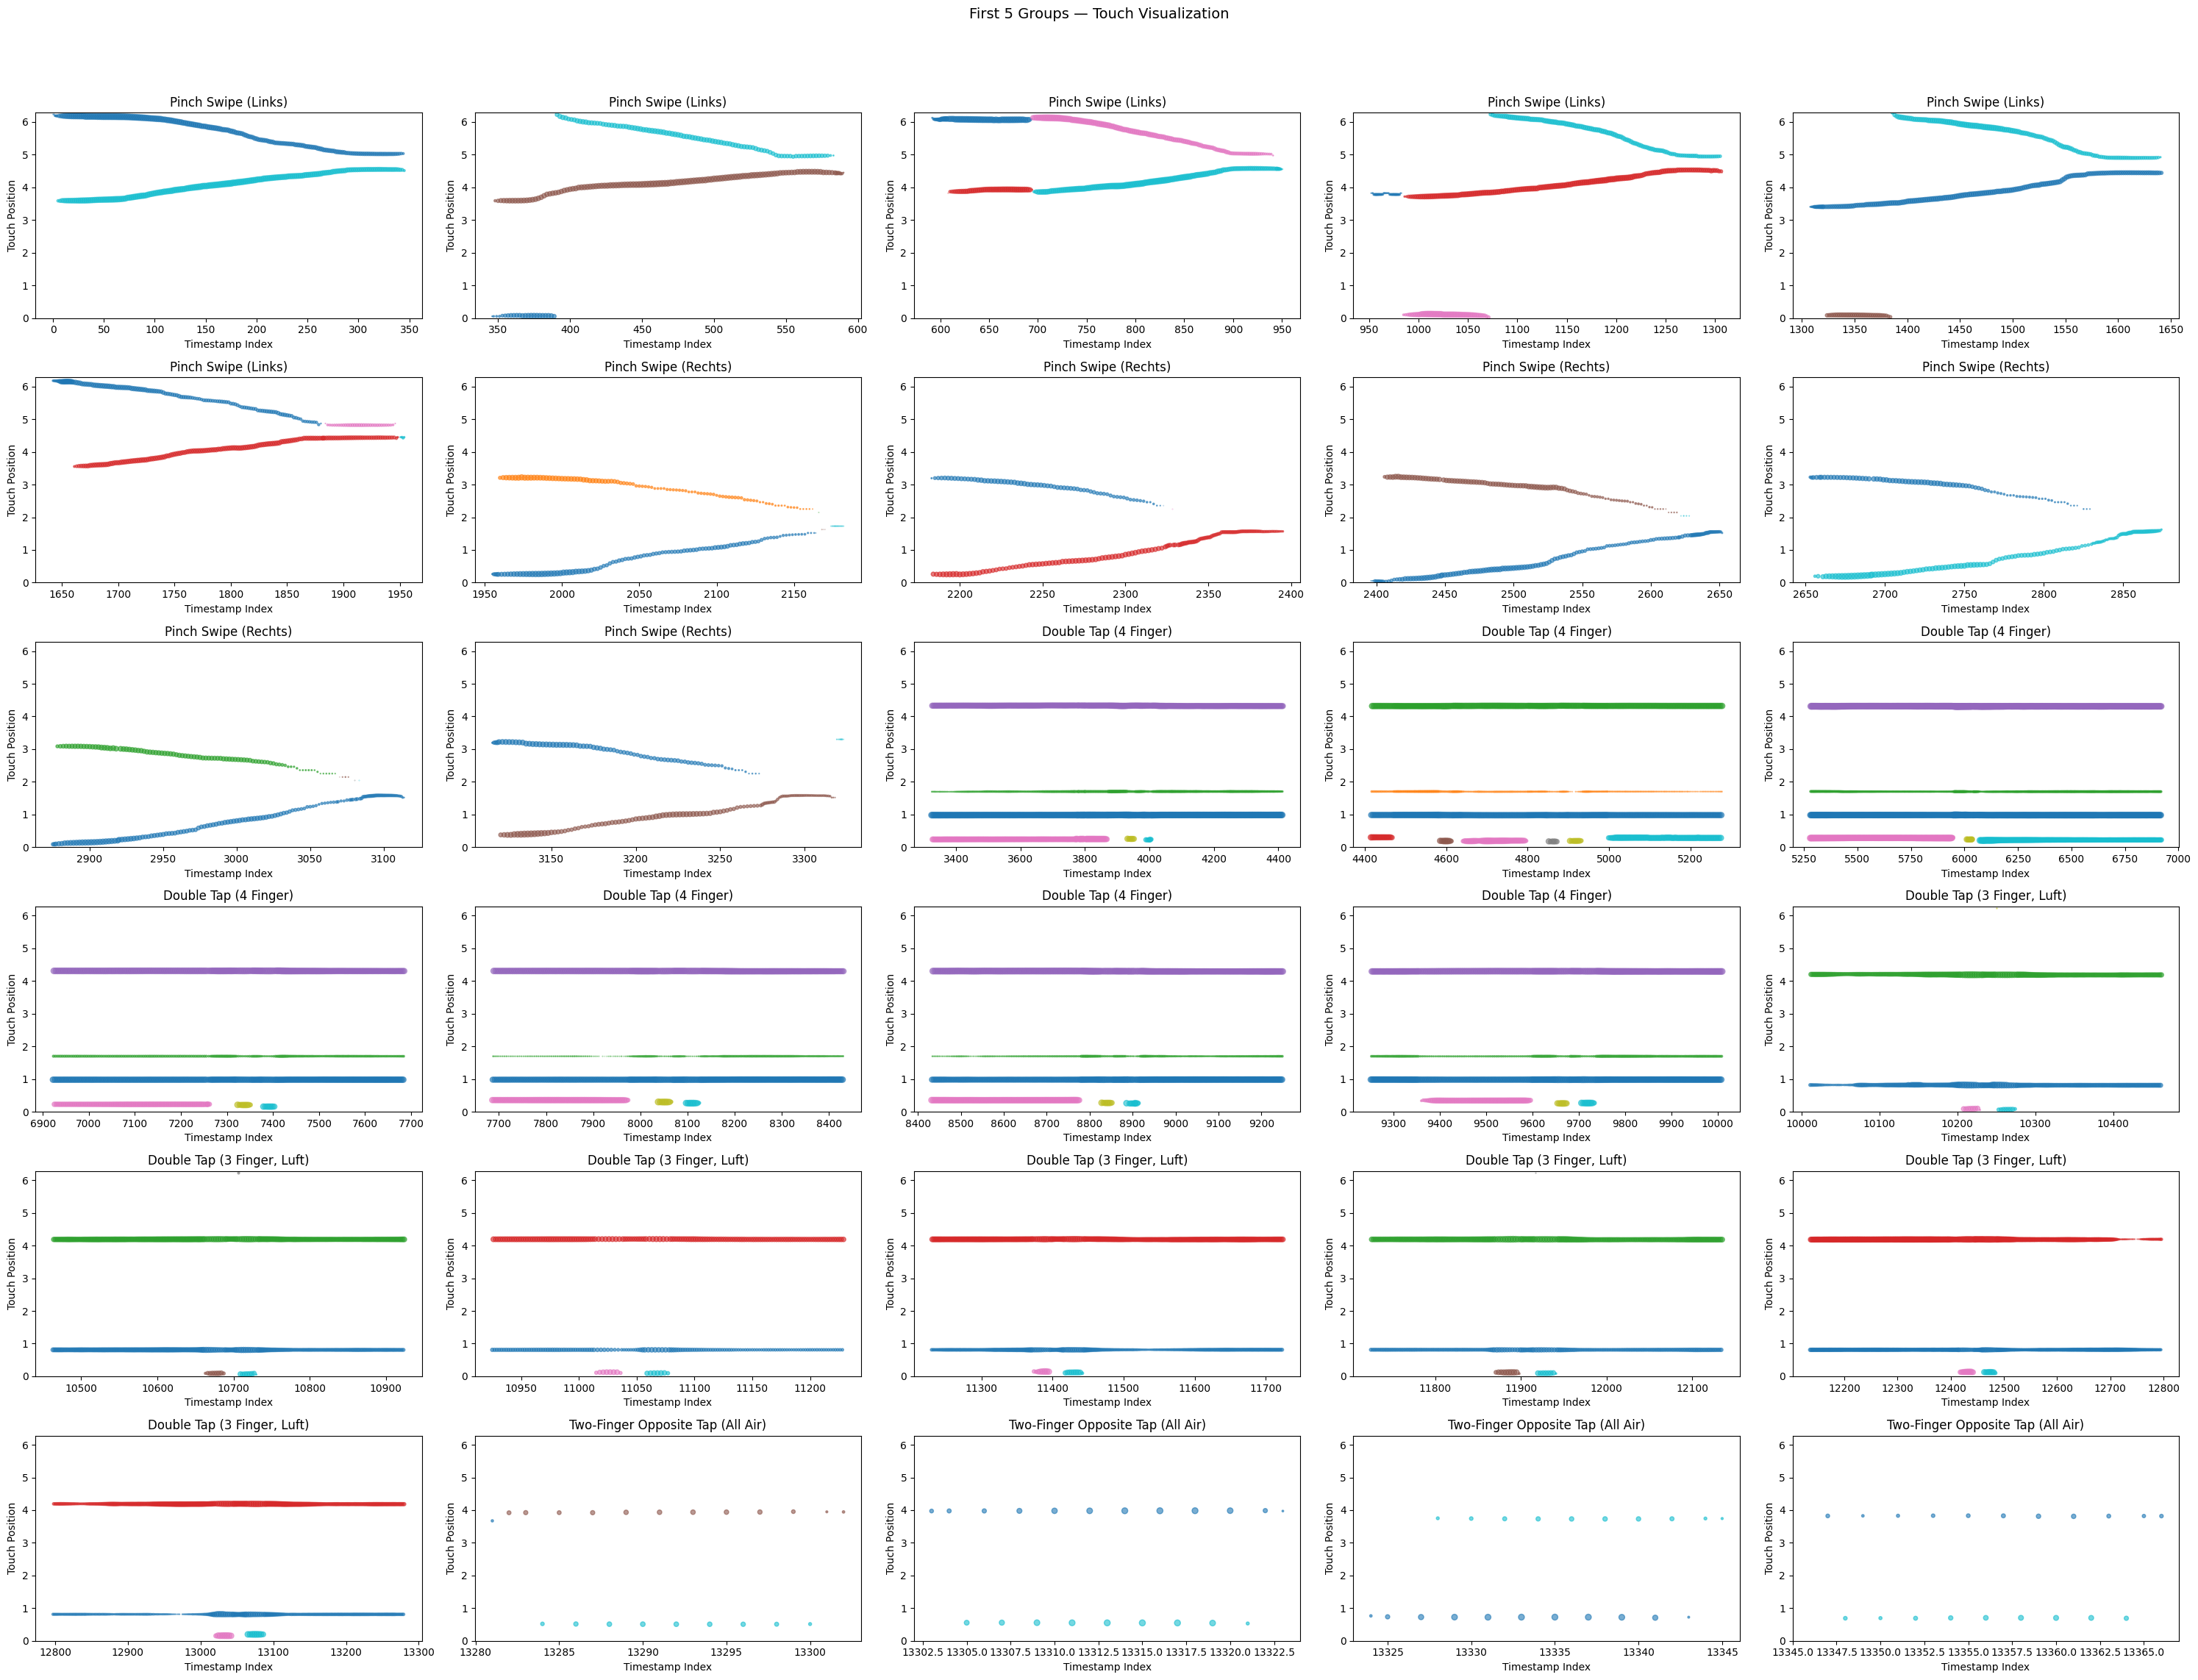

In [23]:

# Get up to the first 5 unique group_ids
group_ids = grouped_df['group_id'].unique()[:30]
num_groups = len(group_ids)

if num_groups > 0:
    # --- Prepare figure layout ---
    cols = 5  # Number of plots per row
    rows = (num_groups + cols - 1) // cols  # Compute number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for i, group_id in enumerate(group_ids):
        ax = axes[i]

        # Filter data for this group
        group_data = grouped_df[grouped_df['group_id'] == group_id].copy()

        # Skip empty groups
        if group_data.empty:
            ax.set_visible(False)
            continue

        # --- Define color mapping per group ---
        unique_touch_ids = sorted(group_data['touch_id'].unique())
        num_touches = len(unique_touch_ids)
        cmap = cm.get_cmap('tab10', num_touches)
        touch_id_to_color = {
            touch_id: cmap(j % cmap.N)
            for j, touch_id in enumerate(unique_touch_ids)
        }

        # --- Plot all touches in this group ---
        for touch_id in unique_touch_ids:
            touch_df = group_data[group_data['touch_id'] == touch_id]

            x_values = touch_df.index  # or touch_df['timestamp'] if available
            s_values = touch_df['pressure_norm'].fillna(100).apply(lambda p: p * 35)

            ax.scatter(
                x_values,
                touch_df['position'],
                s=s_values,
                c=[touch_id_to_color[touch_id]],
                alpha=0.6,
                label=f"Touch {touch_id}",
            )

            # Todo Add motor angle as well

        ax.set_title(touch_df['gesture'].iloc[0])
        ax.set_xlabel("Timestamp Index")
        ax.set_ylabel("Touch Position")
        ax.set_ylim(0, 2 * np.pi)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("First 5 Groups — Touch Visualization", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No groups found in the dataset.")

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\2966194532.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_touches)


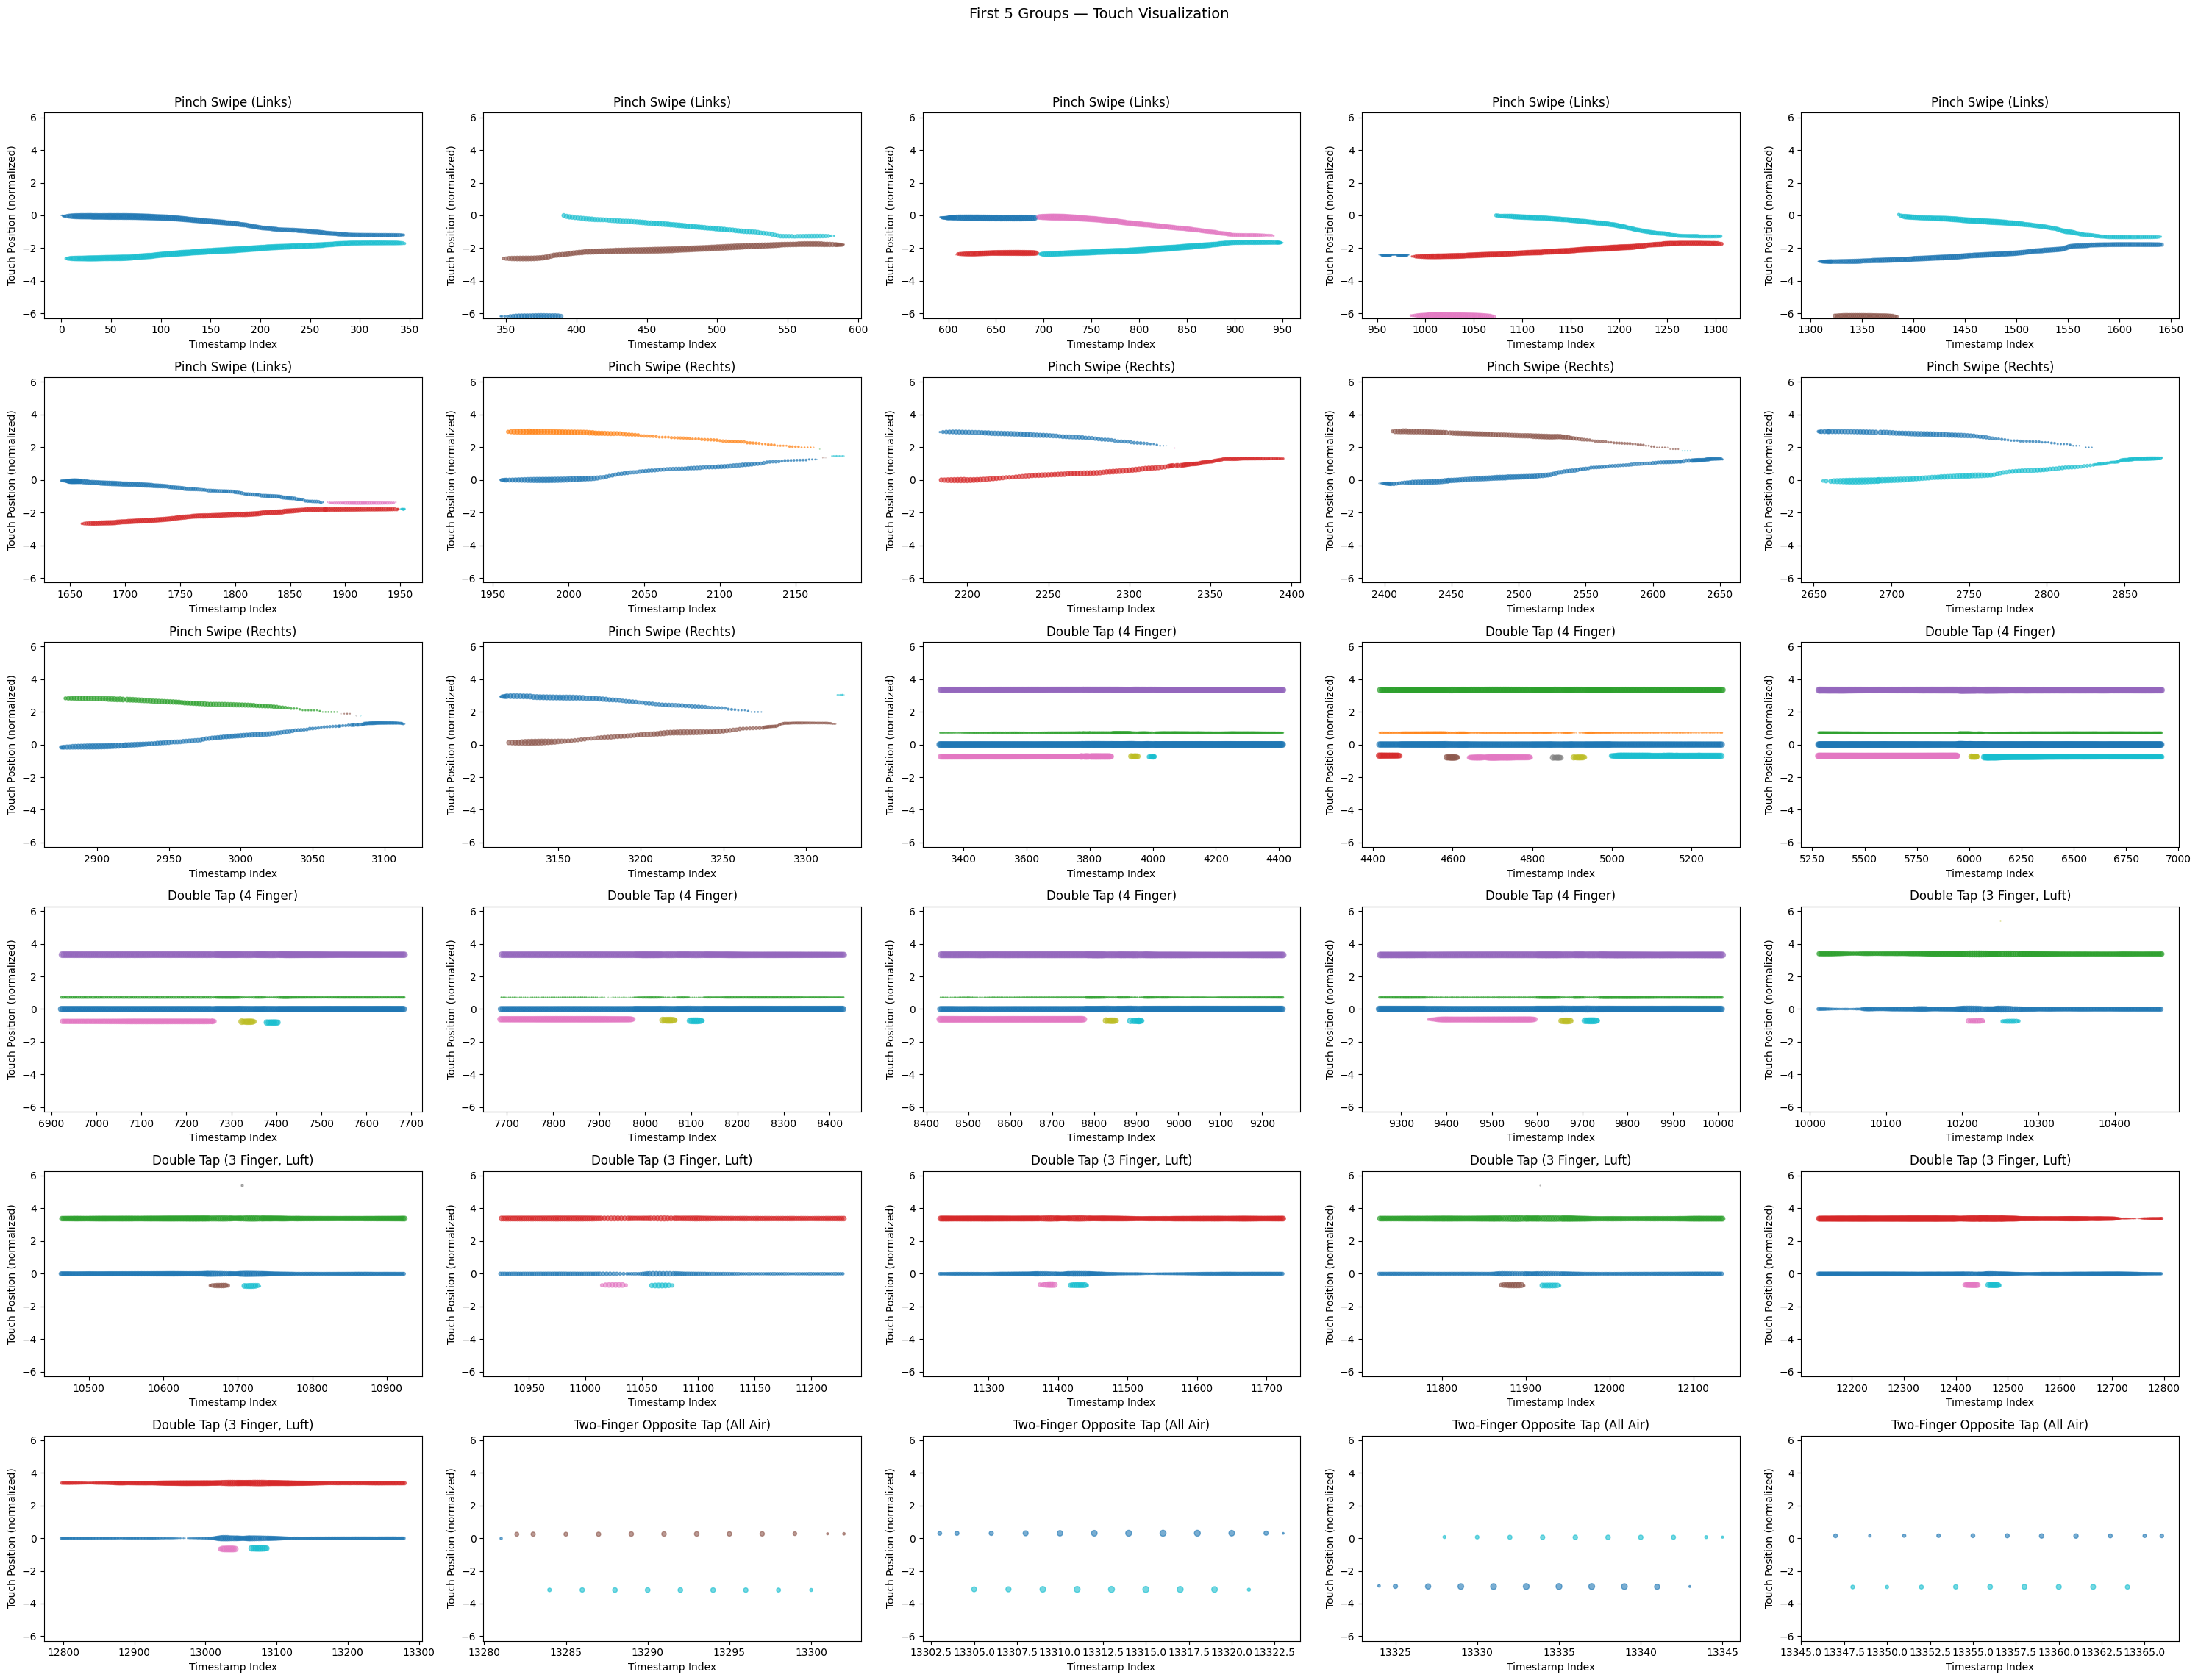

In [24]:

# Get up to the first 5 unique group_ids
group_ids = grouped_df['group_id'].unique()[:30]
num_groups = len(group_ids)

if num_groups > 0:
    # --- Prepare figure layout ---
    cols = 5  # Number of plots per row
    rows = (num_groups + cols - 1) // cols  # Compute number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for i, group_id in enumerate(group_ids):
        ax = axes[i]

        # Filter data for this group
        group_data = grouped_df[grouped_df['group_id'] == group_id].copy()

        # Skip empty groups
        if group_data.empty:
            ax.set_visible(False)
            continue

        # --- Define color mapping per group ---
        unique_touch_ids = sorted(group_data['touch_id'].unique())
        num_touches = len(unique_touch_ids)
        cmap = cm.get_cmap('tab10', num_touches)
        touch_id_to_color = {
            touch_id: cmap(j % cmap.N)
            for j, touch_id in enumerate(unique_touch_ids)
        }

        # --- Plot all touches in this group ---
        for touch_id in unique_touch_ids:
            touch_df = group_data[group_data['touch_id'] == touch_id]

            x_values = touch_df.index  # or touch_df['timestamp'] if available
            s_values = touch_df['pressure_norm'].fillna(100).apply(lambda p: p * 35)

            ax.scatter(
                x_values,
                touch_df['position_norm'],
                s=s_values,
                c=[touch_id_to_color[touch_id]],
                alpha=0.6,
                label=f"Touch {touch_id}",
            )

            # Todo Add motor angle as well

        ax.set_title(touch_df['gesture'].iloc[0])
        ax.set_xlabel("Timestamp Index")
        ax.set_ylabel("Touch Position (normalized)")
        ax.set_ylim(-2 * np.pi, 2 * np.pi)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("First 5 Groups — Touch Visualization", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No groups found in the dataset.")

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\647615205.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_touches)


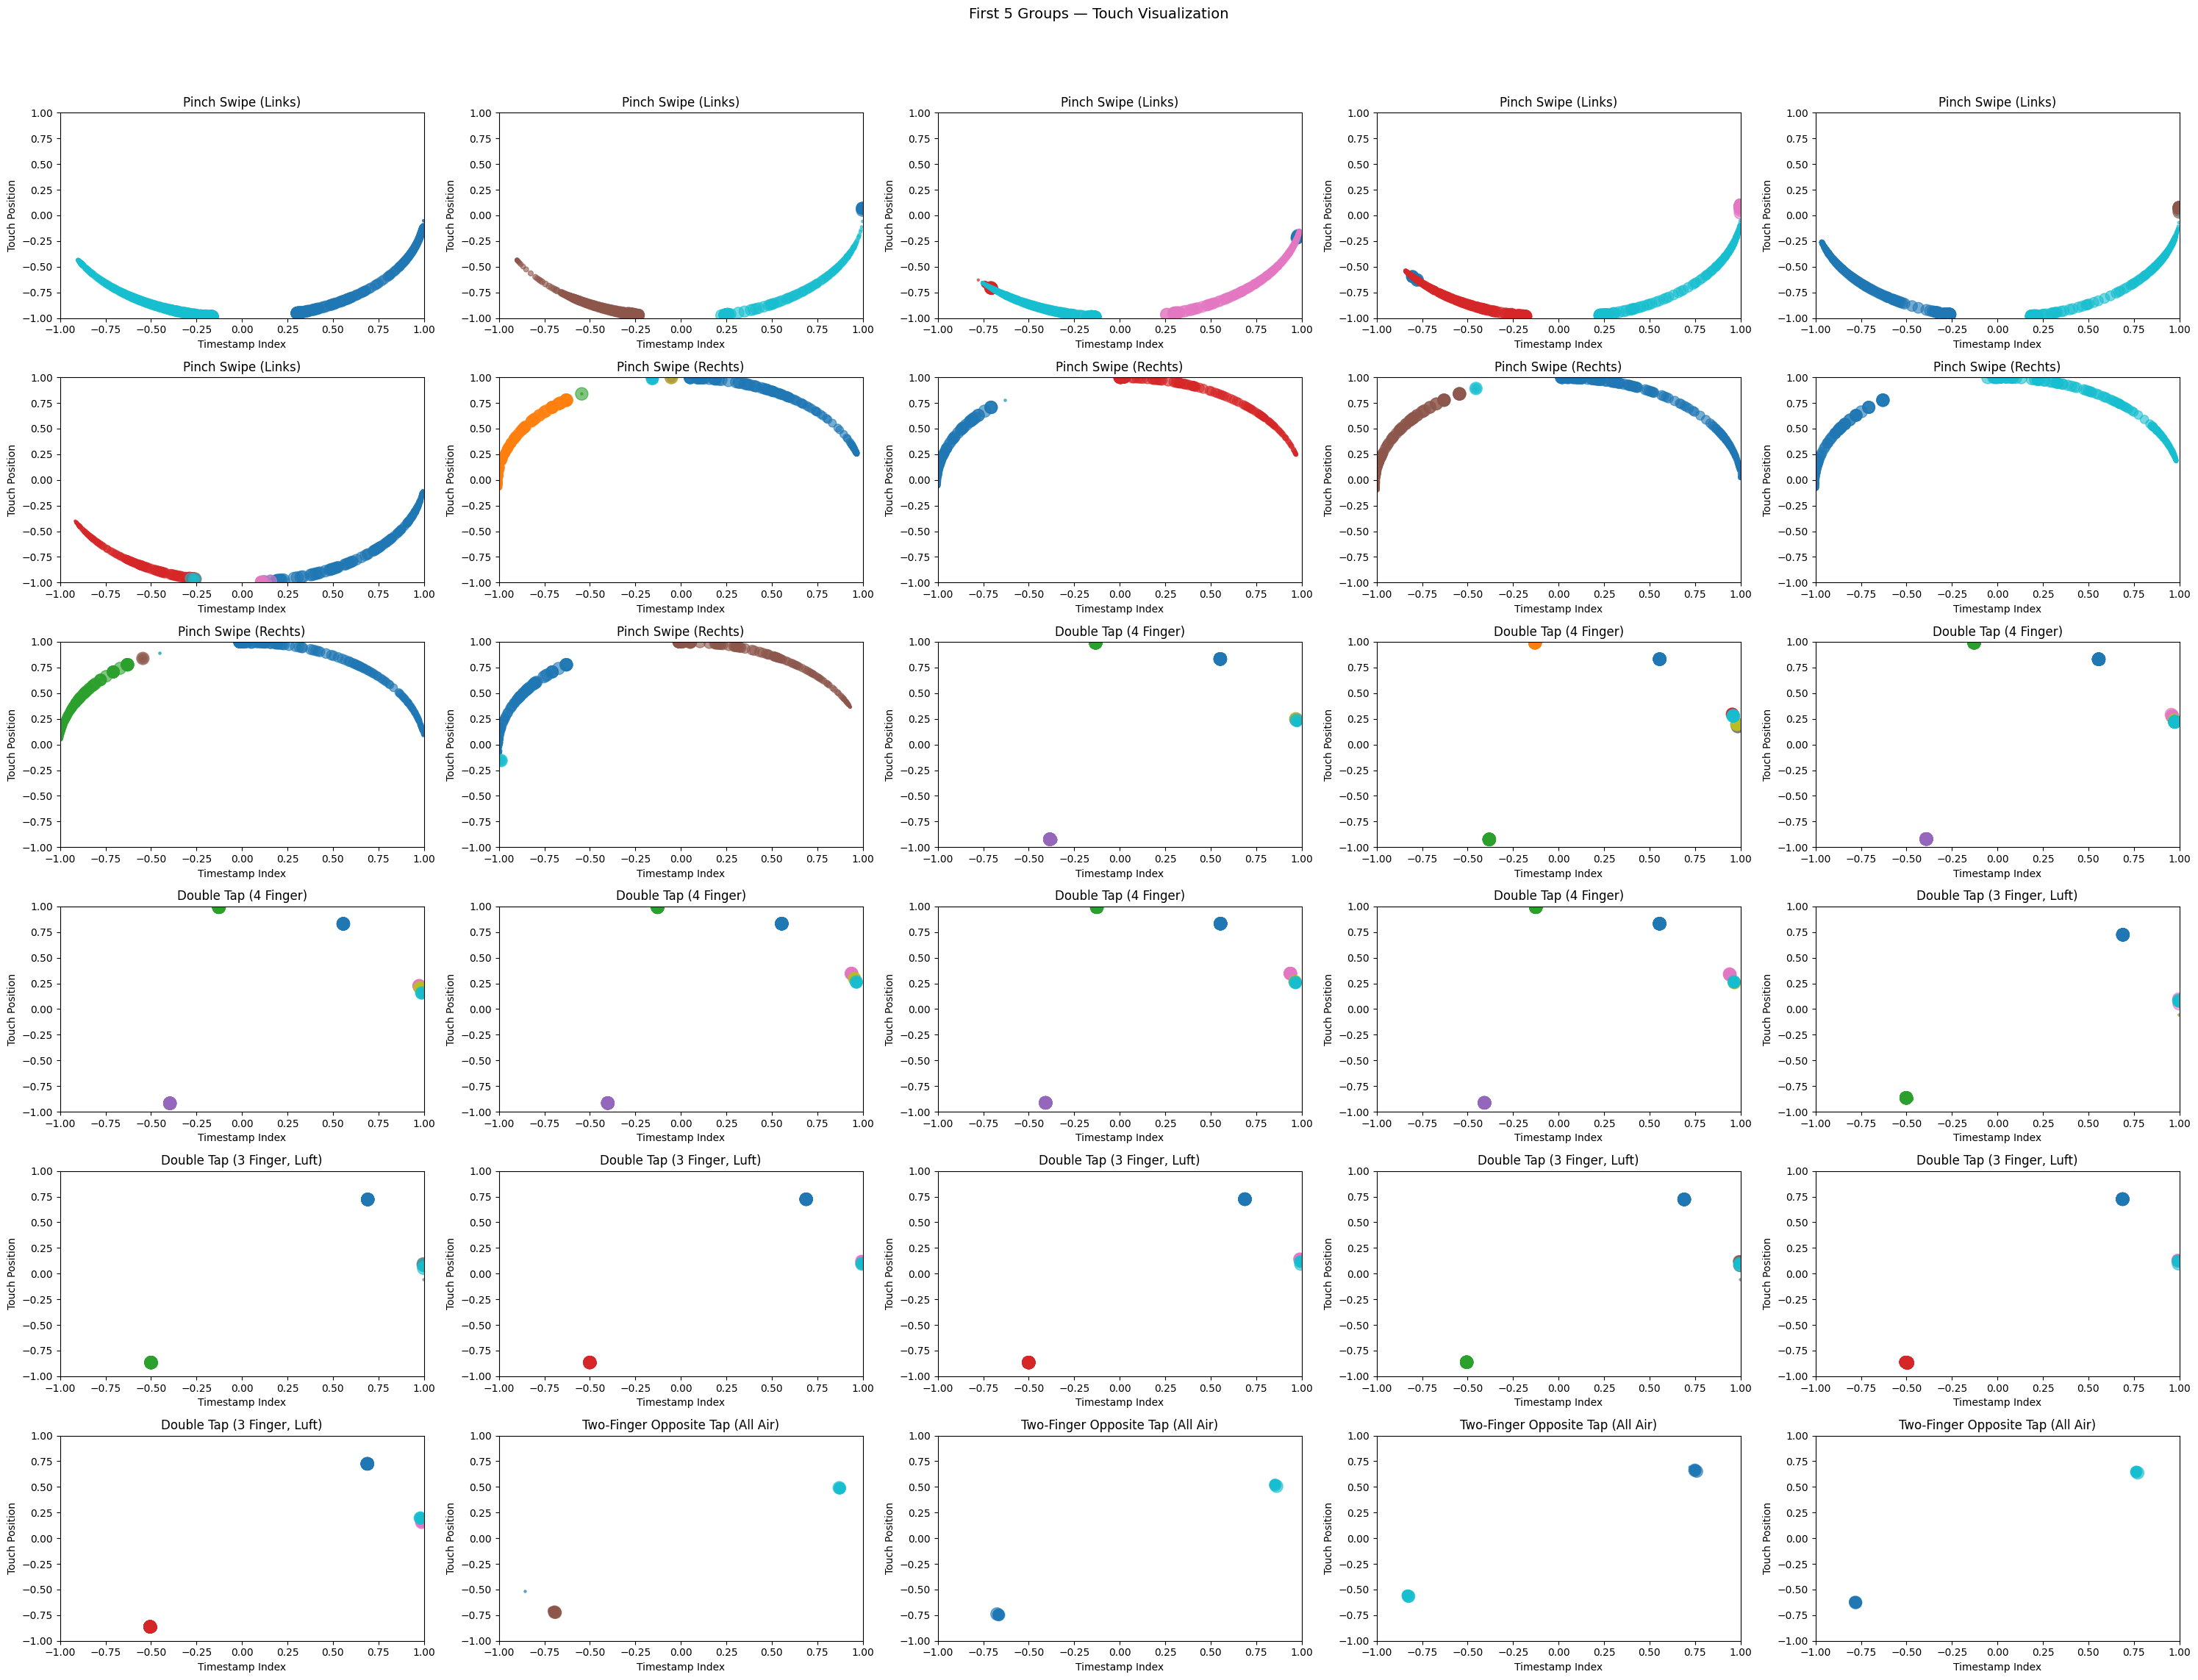

In [25]:
# display the first group touch positions, but calculate the x and y through cosine and sine of the position angle, where the size is translated between 1 and 10 based on the index and the color based on the touch_id

if num_groups > 0:
    # --- Prepare figure layout ---
    cols = 5  # Number of plots per row
    rows = (num_groups + cols - 1) // cols  # Compute number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for i, group_id in enumerate(group_ids):
        ax = axes[i]

        # Filter data for this group
        group_data = grouped_df[grouped_df['group_id'] == group_id].copy()

        # Skip empty groups
        if group_data.empty:
            ax.set_visible(False)
            continue

        # --- Define color mapping per group ---
        unique_touch_ids = sorted(group_data['touch_id'].unique())
        num_touches = len(unique_touch_ids)
        cmap = cm.get_cmap('tab10', num_touches)
        touch_id_to_color = {
            touch_id: cmap(j % cmap.N)
            for j, touch_id in enumerate(unique_touch_ids)
        }

        # --- Plot all touches in this group ---
        for touch_id in unique_touch_ids:
            touch_df = group_data[group_data['touch_id'] == touch_id]

            x_values = np.cos(touch_df['position'])
            y_values = np.sin(touch_df['position'])
            sizes = np.linspace(5, 150, len(touch_df))

            ax.scatter(
                x_values, 
                y_values, 
                s=sizes,
                c=[touch_id_to_color[touch_id]],
                alpha=0.6,
                label=f"Touch {touch_id}",
            )

        ax.set_title(touch_df['gesture'].iloc[0])
        ax.set_xlabel("Timestamp Index")
        ax.set_ylabel("Touch Position")
        ax.set_ylim(-1, 1)
        ax.set_xlim(-1, 1)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("First 5 Groups — Touch Visualization", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [26]:
def get_gesture_for_group_id(group_id):
    # get gesture name from session_task_id from the grouped_df
    gesture = grouped_df[grouped_df['group_id'] == group_id]['gesture'].iloc[0]
    return gesture

def get_distance_df(group_by, fast=True, limit=None, progress_logs=False):
    # --- 1. Precompute unique session_task_ids ---
    session_task_ids = grouped_df['session_task_id'].unique()
    if len(session_task_ids) < 2:
        raise ValueError("Need at least two session_task_ids to compare.")
    session_tasks_to_consider = session_task_ids if limit is None else session_task_ids[:limit]

    # --- 2. Precompute gesture lookup ---
    gesture_lookup = grouped_df.set_index('group_id')['gesture'].to_dict()

    # --- 3. Pre-split grouped_df by session_task_id for faster filtering ---
    grouped_by_task = {task_id: grouped_df[grouped_df['session_task_id'] == task_id] for task_id in session_tasks_to_consider}

    # --- 4. Extract and normalize time series once per group_id ---
    def extract_time_series(group_data):
        """Returns normalized time series for the selected group_by columns."""
        x = group_data.index
        series_list = []
        for col in group_by:
            y = group_data.groupby(x)[col].mean().astype(np.float64)
            y = (y - y.mean()) / (y.std() + 1e-8)
            series_list.append(y.values)
        return np.column_stack(series_list)

    group_series = defaultdict(dict)
    for task_id, df_task in grouped_by_task.items():
        for gid, group_data in df_task.groupby('group_id'):
            group_series[task_id][gid] = extract_time_series(group_data)

    # --- 5. Compute DTW distances ---
    length_all_groups = sum(len(v) for v in group_series.values()) / len(group_series)
    total_combinations = math.comb(len(session_tasks_to_consider), 2) * (length_all_groups ** 2)
    results = []

    current_progress = 0
    start_time = time.time()
    last_log_time = start_time

    for task_a, task_b in itertools.combinations_with_replacement(session_tasks_to_consider, 2):
        groups_a = group_series[task_a]
        groups_b = group_series[task_b]

        for gid_a, ts_a in groups_a.items():
            for gid_b, ts_b in groups_b.items():
                dist = dtw_ndim.distance_fast(ts_a, ts_b) if fast else dtw_ndim.distance(ts_a, ts_b)
                results.append({
                    'group_1': gid_a,
                    'group_2': gid_b,
                    'session_task_1': gesture_lookup[gid_a],
                    'session_task_2': gesture_lookup[gid_b],
                    'dtw_distance': dist
                })
                current_progress += 1

                # --- Progress + ETA logging ---
                if progress_logs and current_progress % 100 == 0:
                    now = time.time()
                    elapsed = now - start_time
                    avg_per_item = elapsed / current_progress
                    remaining = total_combinations - current_progress
                    eta_seconds = remaining * avg_per_item
                    eta_minutes = eta_seconds / 60

                    # Format nicely
                    if eta_minutes < 1:
                        eta_str = f"{eta_seconds:.1f}s"
                    elif eta_minutes < 60:
                        eta_str = f"{eta_minutes:.1f} min"
                    else:
                        eta_str = f"{eta_minutes / 60:.2f} h"

                    print(f"Computed {current_progress:,}/{int(total_combinations):,} "
                          f"({100 * current_progress / total_combinations:.2f}%) - "
                          f"Elapsed: {elapsed/60:.1f} min, ETA: {eta_str}")

    return pd.DataFrame(results)

def get_participant_id_from_task_id(session_task_id):
    with sqlite3.connect(db_path) as conn:
        query = """
        SELECT s.participant_id
        FROM sessionTask st
        JOIN session s ON st.session_id = s.id
        WHERE st.id = ?
        """
        cursor = conn.execute(query, (session_task_id,))
        result = cursor.fetchone()
        return result[0] if result else None

def get_distance_cluster(group_by, limit=None):
    # --- 1. Get the first two session_task_ids ---
    session_task_ids = grouped_df['session_task_id'].unique()
    if len(session_task_ids) < 2:
        raise ValueError("Need at least two session_task_ids to compare.")

    # --- 2. Prepare helper: extract per-group time series ---
    def extract_time_series(df, group_id):
        """Returns the mean touch position over time for one group."""
        group_data = df[df['group_id'] == group_id].copy()

        x = group_data.index
        # y = group_data.groupby(x)[group_by].mean()
        # return y.values  # return as NumPy array

        series_list = []
        for col in group_by:
            y = group_data.groupby(x)[col].mean()
            series_list.append(y.values)
        # Stack columns -> shape (timesteps, n_features)
        return np.column_stack(series_list)

    session_tasks_to_consider = session_task_ids if limit is None else session_task_ids[:limit]

    # --- 3. Extract time series for each group per session_task_id ---
    all_series = []
    group_ids = []
    for task_id in session_tasks_to_consider:
        task_groups = grouped_df[grouped_df['session_task_id'] == task_id]['group_id'].unique()
        for gid in task_groups:
            ts = extract_time_series(grouped_df, gid)
            all_series.append(ts)
            participant_id = get_participant_id_from_task_id(task_id)
            group_ids.append((participant_id, get_gesture_for_group_id(gid)))

    all_series_clean = []
    for series in all_series:  # all_series = your raw list of time series
        arr = np.array(series, dtype=float)  # convert to 1D float array
        if arr.ndim != 1 and len(group_by) == 1:
            arr = arr.flatten()  # ensure 1D
        all_series_clean.append(arr)
    
    return dtw_ndim.distance_matrix_fast(all_series_clean, compact=False), group_ids

def show_distances_heatmap(distances_df):
    # --- 1. Create the pivot table ---
    pivot_df = distances_df.groupby(
        ['session_task_1', 'session_task_2']
    )['dtw_distance'].median().unstack()

    # --- 2. Plot heatmap ---
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        pivot_df,
        annot=False,
        cmap="viridis",
        fmt=".2f",
        cbar_kws={'label': 'Median DTW Distance'}
    )

    plt.title("Median DTW Distance Matrix Between Tasks")
    plt.xlabel("Session Task 2")
    plt.ylabel("Session Task 1")

    # --- 3. For each row: find the minimum (ignoring NaNs) and draw one rectangle.
    n_cols = pivot_df.shape[1]
    col_index = np.arange(n_cols)

    for i, row_label in enumerate(pivot_df.index):
        row_values = pivot_df.loc[row_label].values.astype(float)

        # Ignore NaNs when finding minimum
        valid_mask = ~np.isnan(row_values)
        if not np.any(valid_mask):
            continue

        # index within the valid positions, convert to global column index
        min_j = np.argmin(row_values[valid_mask])
        min_j_global = col_index[valid_mask][min_j]

        # determine if the chosen min is on the diagonal (same label)
        is_diagonal = (row_label in pivot_df.columns) and (pivot_df.columns.get_loc(row_label) == min_j_global)

        # choose color: green if correct diagonal match, otherwise red
        edgecolor = 'white' if is_diagonal else 'red'

        rect = Rectangle(
            (min_j_global, i),  # (x, y)
            1, 1,               # width, height of one cell
            fill=False,
            edgecolor=edgecolor,
            linewidth=2.5,
            zorder=5
        )
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

Computed 100/207,873 (0.05%) - Elapsed: 0.0 min, ETA: 1.8 min
Computed 200/207,873 (0.10%) - Elapsed: 0.0 min, ETA: 1.6 min
Computed 300/207,873 (0.14%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 400/207,873 (0.19%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 500/207,873 (0.24%) - Elapsed: 0.0 min, ETA: 1.6 min
Computed 600/207,873 (0.29%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 700/207,873 (0.34%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 800/207,873 (0.38%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 900/207,873 (0.43%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,000/207,873 (0.48%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,100/207,873 (0.53%) - Elapsed: 0.0 min, ETA: 1.3 min
Computed 1,200/207,873 (0.58%) - Elapsed: 0.0 min, ETA: 1.3 min
Computed 1,300/207,873 (0.63%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,400/207,873 (0.67%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,500/207,873 (0.72%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,600/207,873 (0.77%) - Elapsed: 0.0 min, ETA: 1.

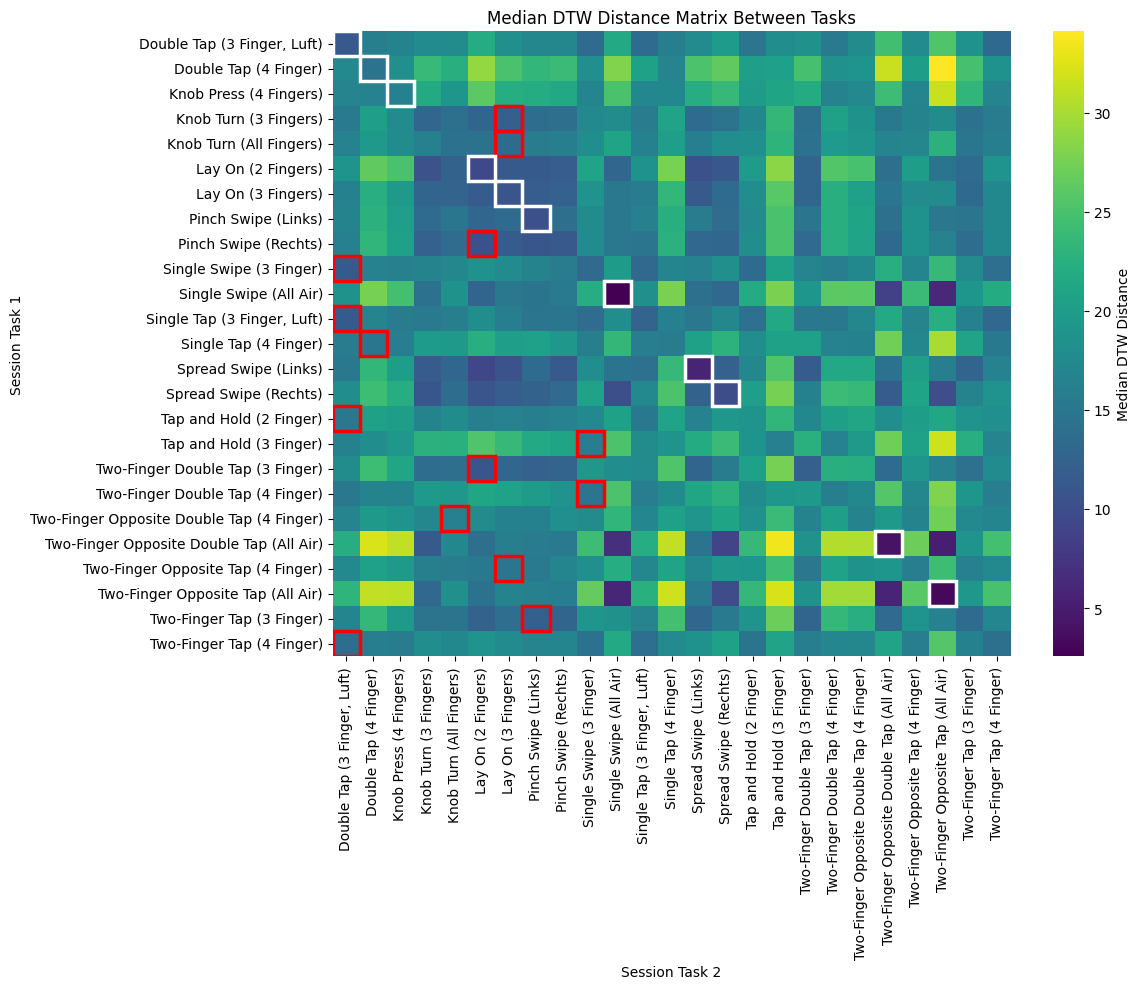

In [27]:
show_distances_heatmap(get_distance_df(['position'], progress_logs=True))

Computed 100/207,873 (0.05%) - Elapsed: 0.0 min, ETA: 1.8 min
Computed 200/207,873 (0.10%) - Elapsed: 0.0 min, ETA: 1.6 min
Computed 300/207,873 (0.14%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 400/207,873 (0.19%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 500/207,873 (0.24%) - Elapsed: 0.0 min, ETA: 1.6 min
Computed 600/207,873 (0.29%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 700/207,873 (0.34%) - Elapsed: 0.0 min, ETA: 1.5 min
Computed 800/207,873 (0.38%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 900/207,873 (0.43%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,000/207,873 (0.48%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,100/207,873 (0.53%) - Elapsed: 0.0 min, ETA: 1.3 min
Computed 1,200/207,873 (0.58%) - Elapsed: 0.0 min, ETA: 1.3 min
Computed 1,300/207,873 (0.63%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,400/207,873 (0.67%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,500/207,873 (0.72%) - Elapsed: 0.0 min, ETA: 1.4 min
Computed 1,600/207,873 (0.77%) - Elapsed: 0.0 min, ETA: 1.

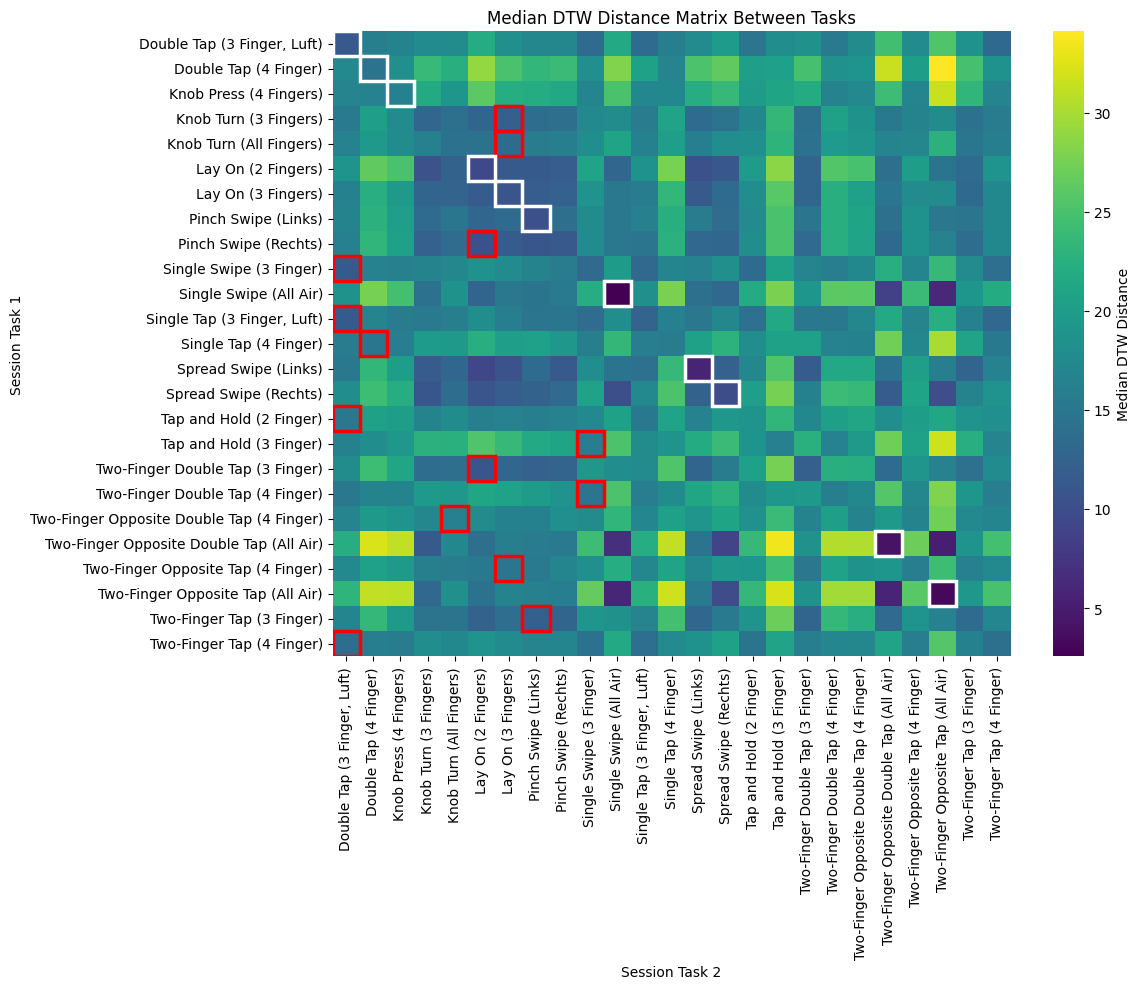

In [28]:
show_distances_heatmap(get_distance_df(['position_norm'], progress_logs=True))

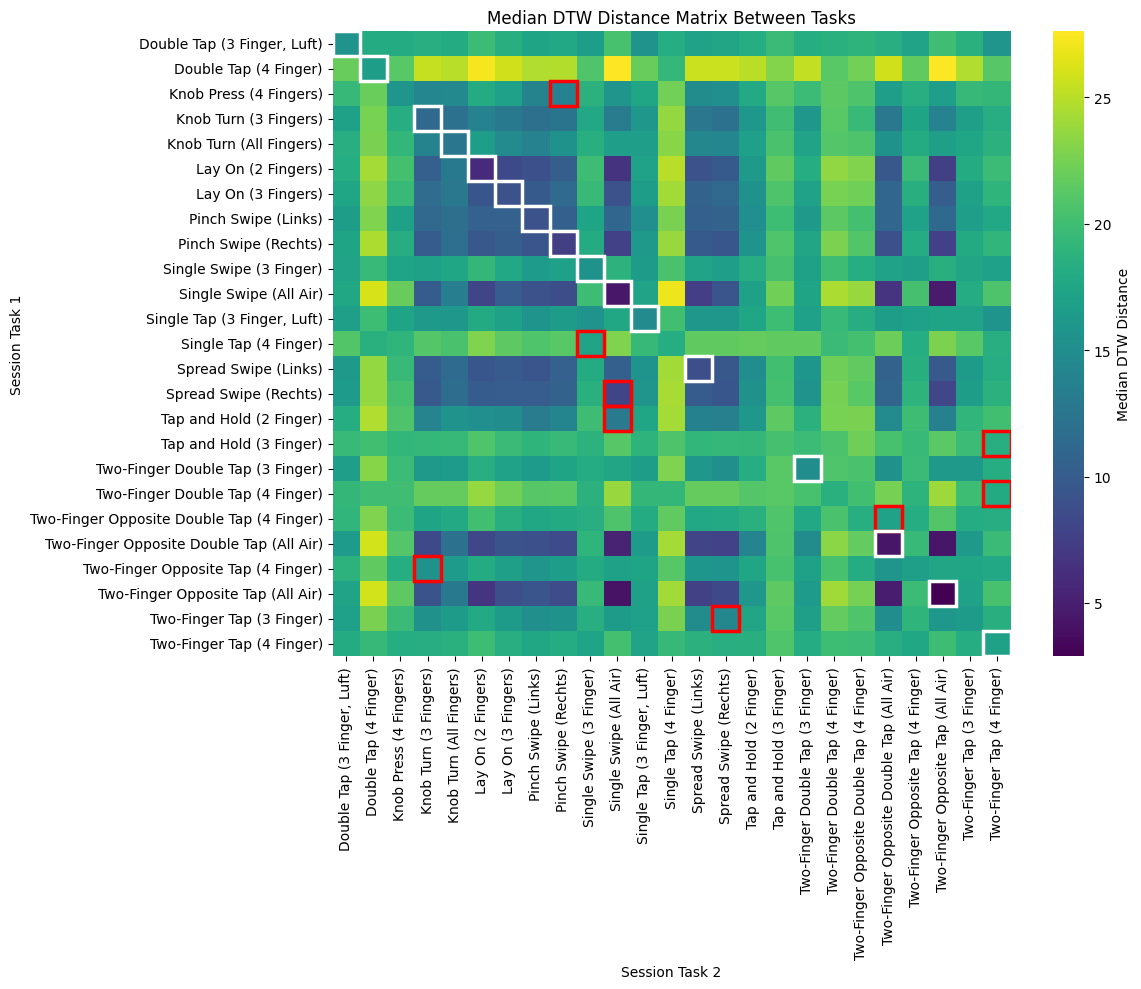

In [29]:
show_distances_heatmap(get_distance_df(['pressure']))

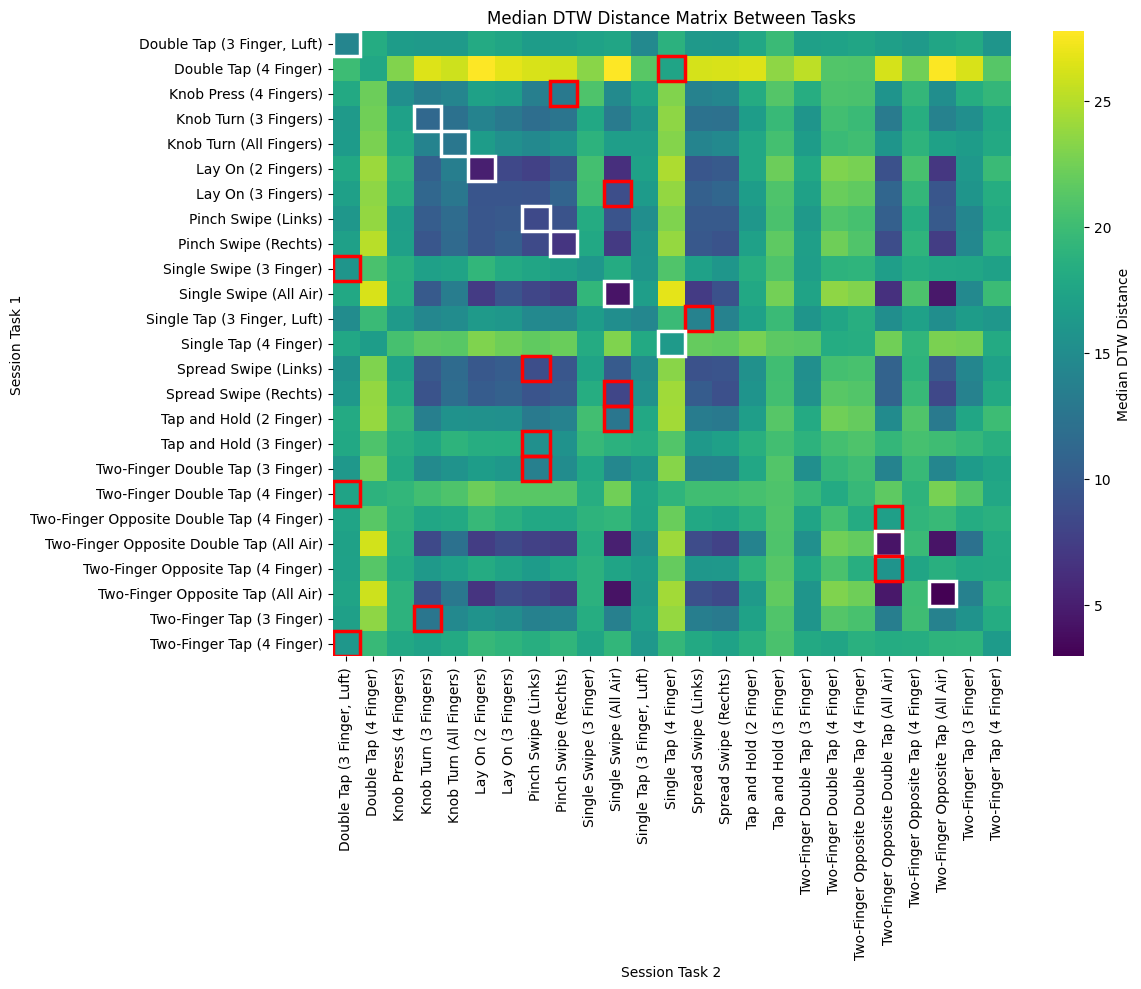

In [30]:
show_distances_heatmap(get_distance_df(['pressure_norm']))

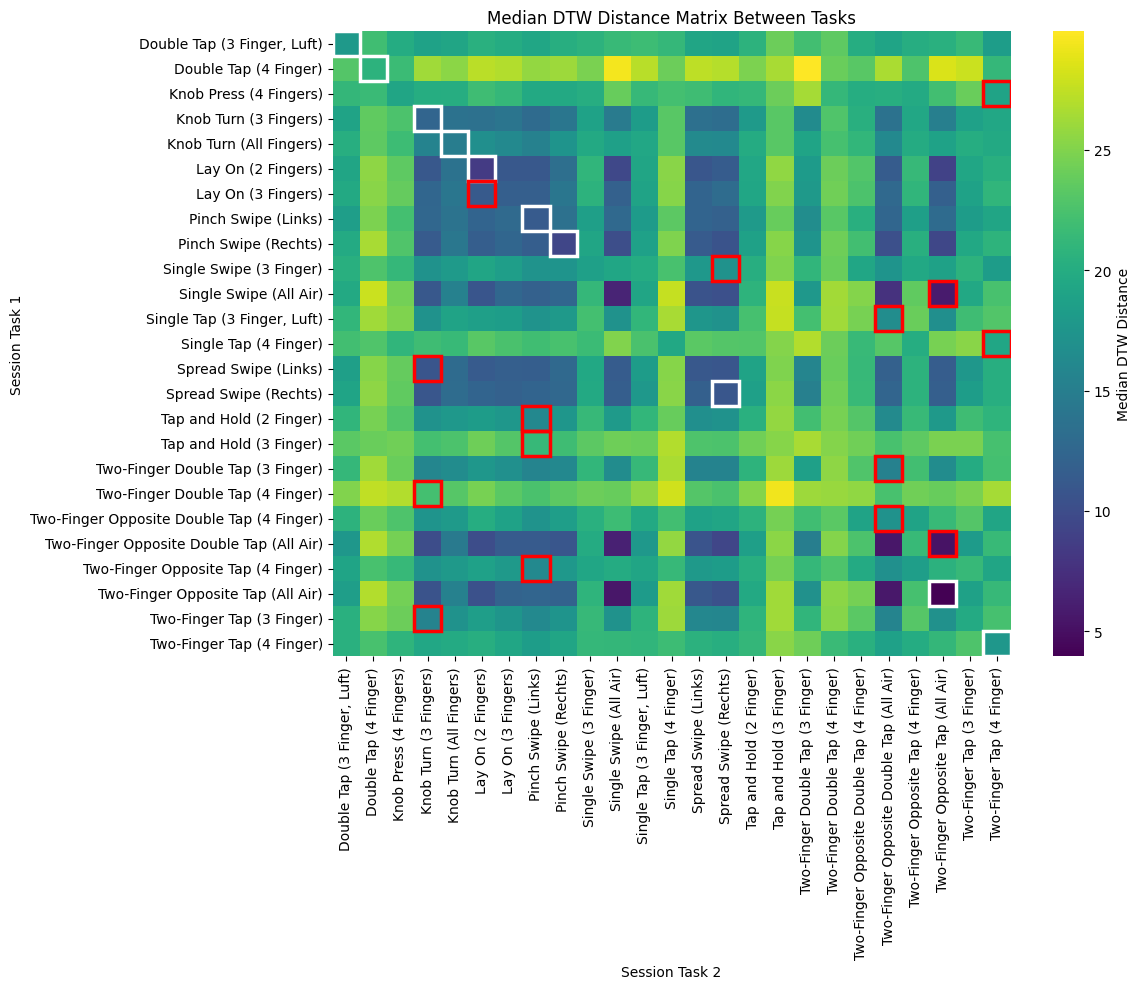

In [31]:
show_distances_heatmap(get_distance_df(['channel']))

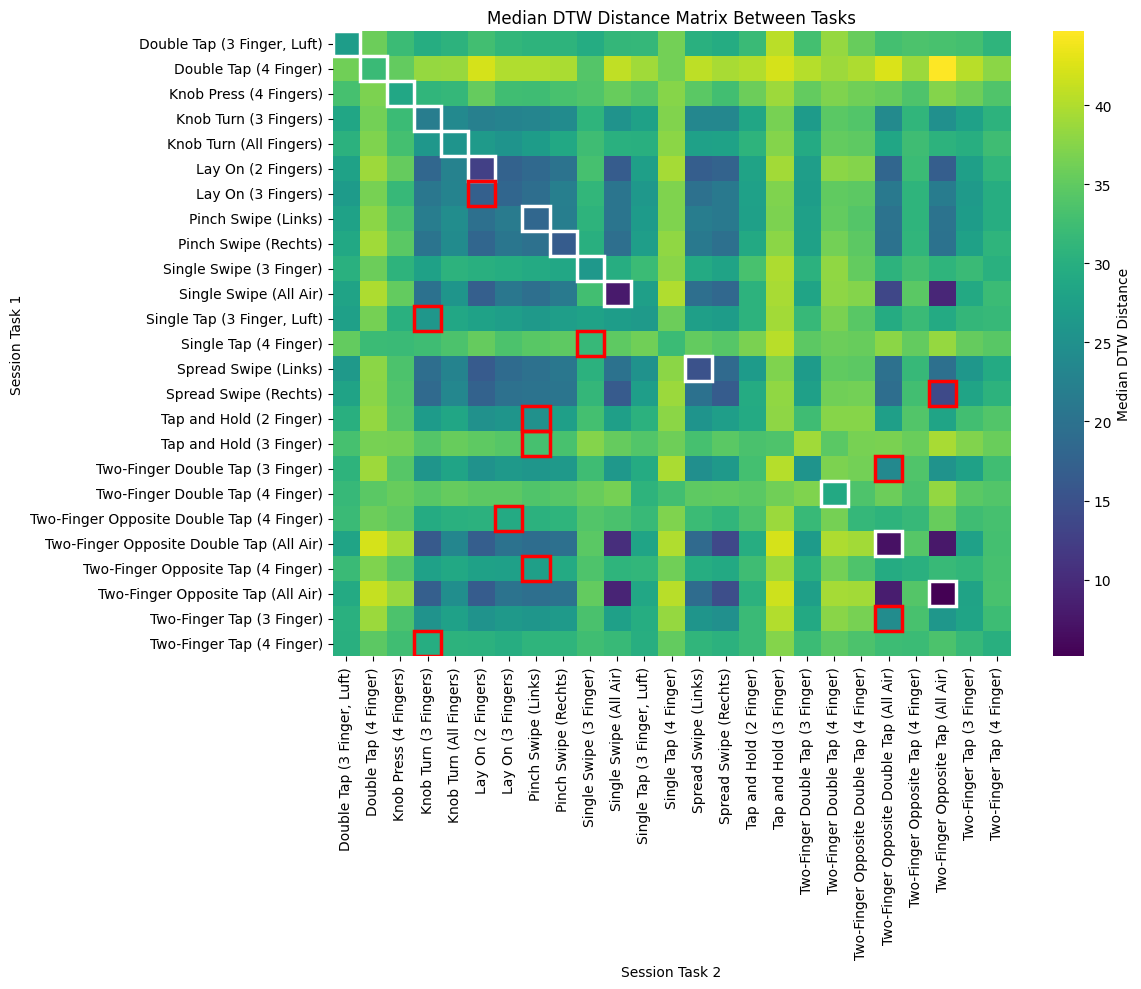

In [32]:
show_distances_heatmap(get_distance_df(['position', 'pressure']))

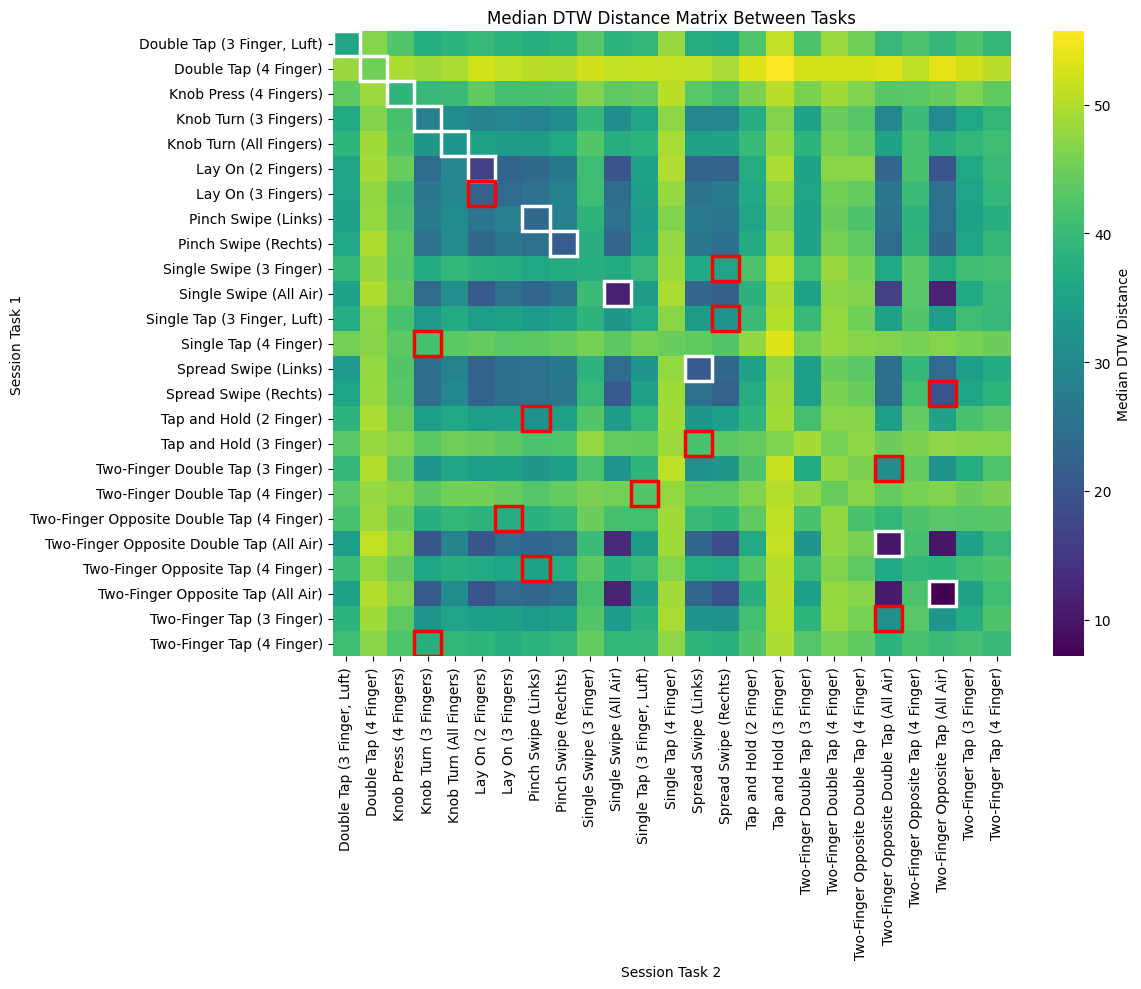

In [33]:
show_distances_heatmap(get_distance_df(['position', 'pressure', 'channel']))

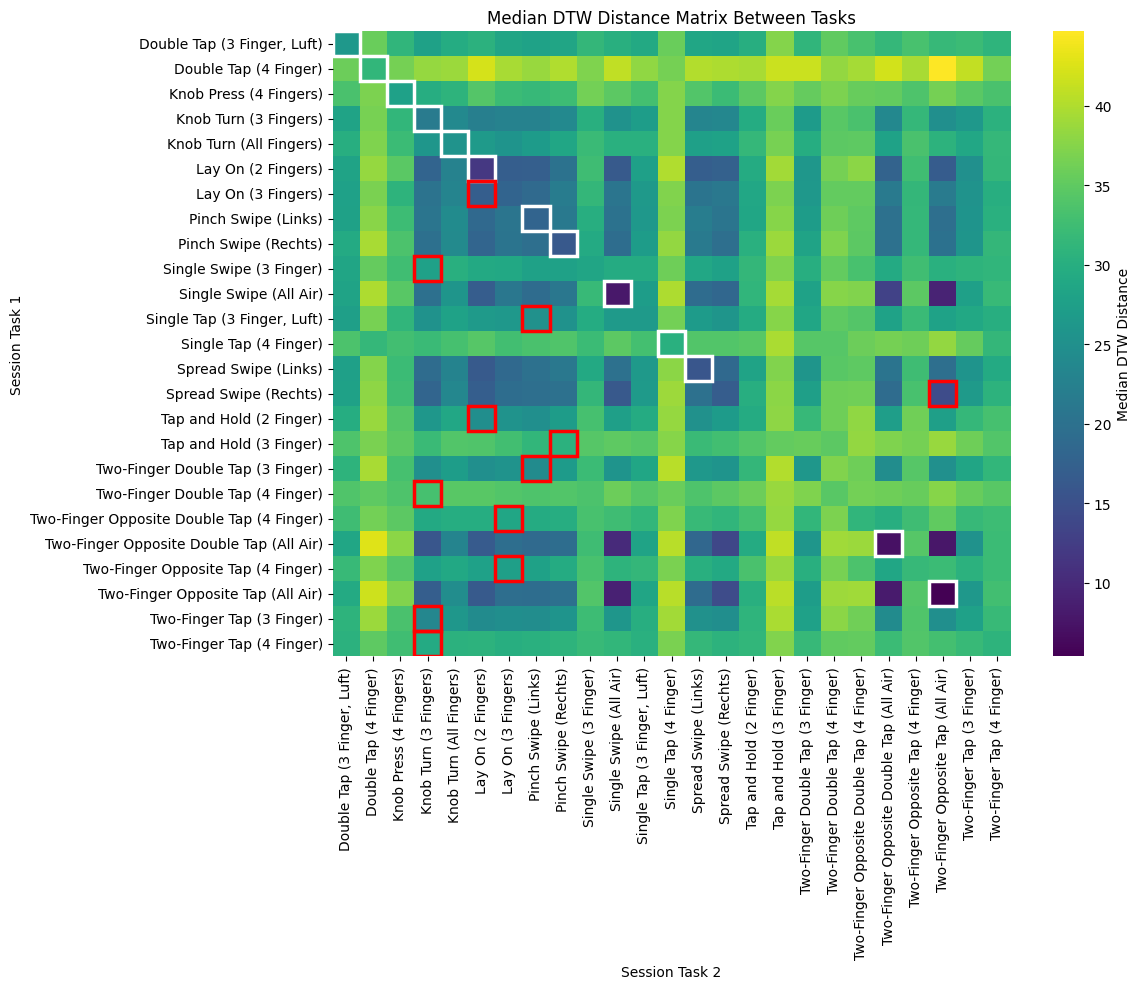

In [34]:
show_distances_heatmap(get_distance_df(['position_norm', 'pressure_norm']))

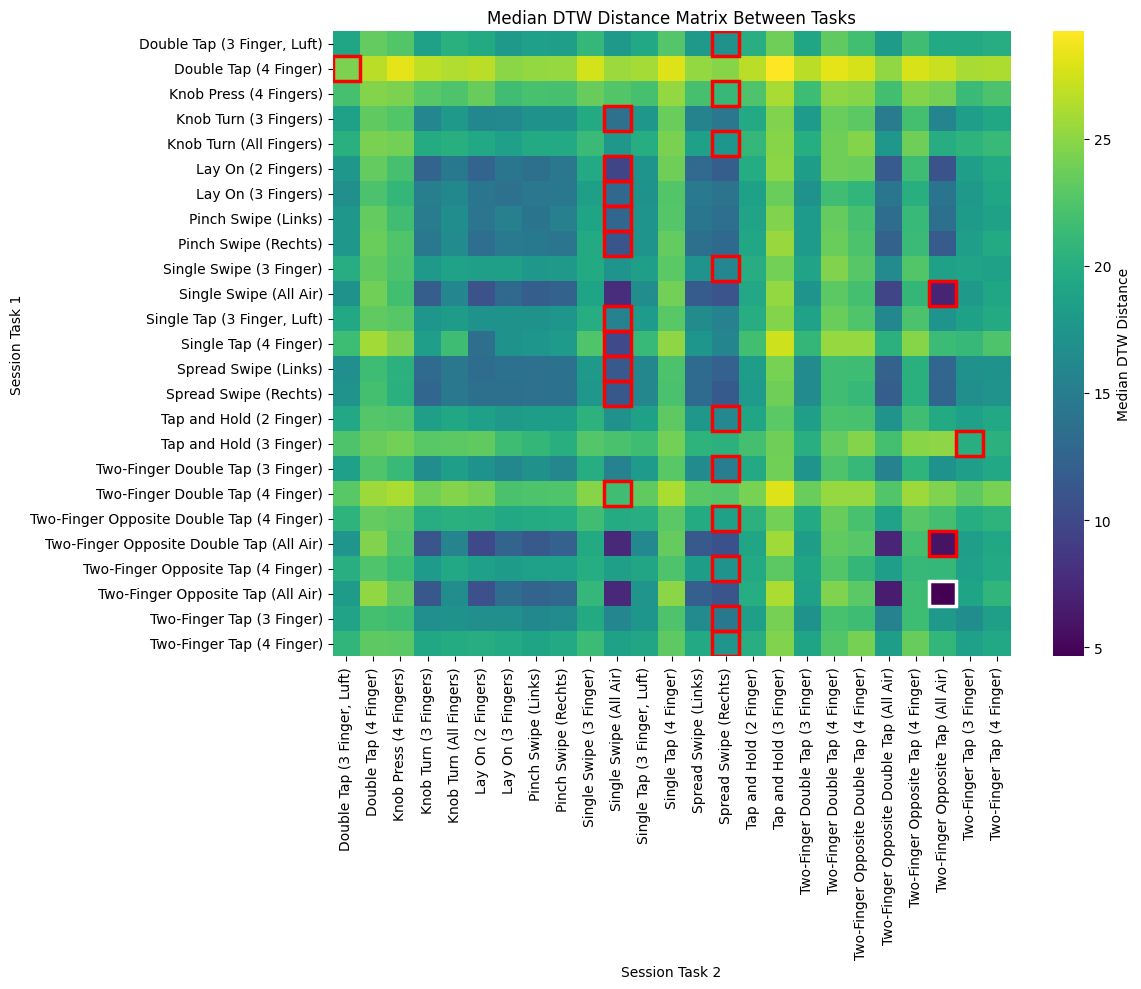

In [35]:
show_distances_heatmap(get_distance_df(['angular_velocity']))

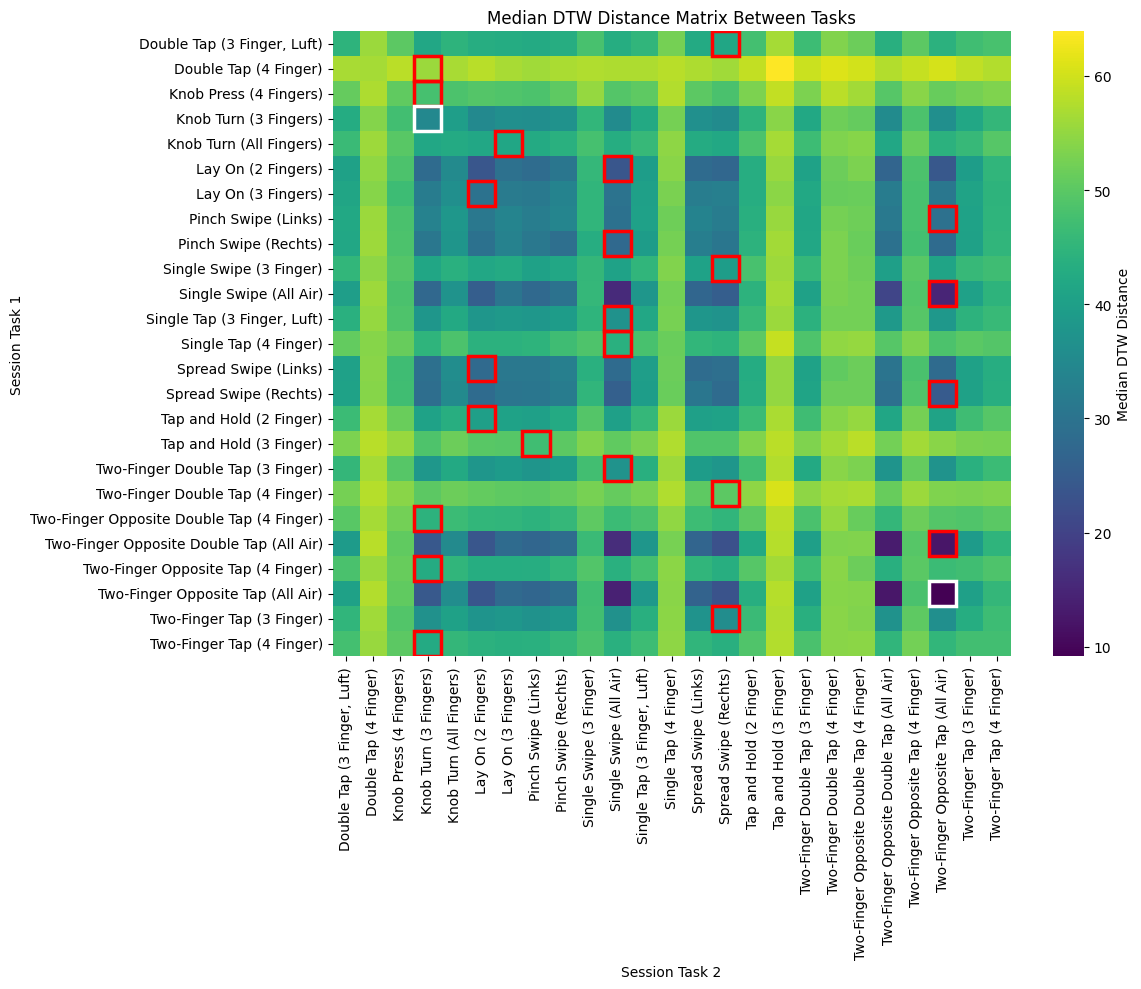

In [36]:
show_distances_heatmap(get_distance_df(['position_norm','pressure_norm','angular_velocity','angular_acceleration']))

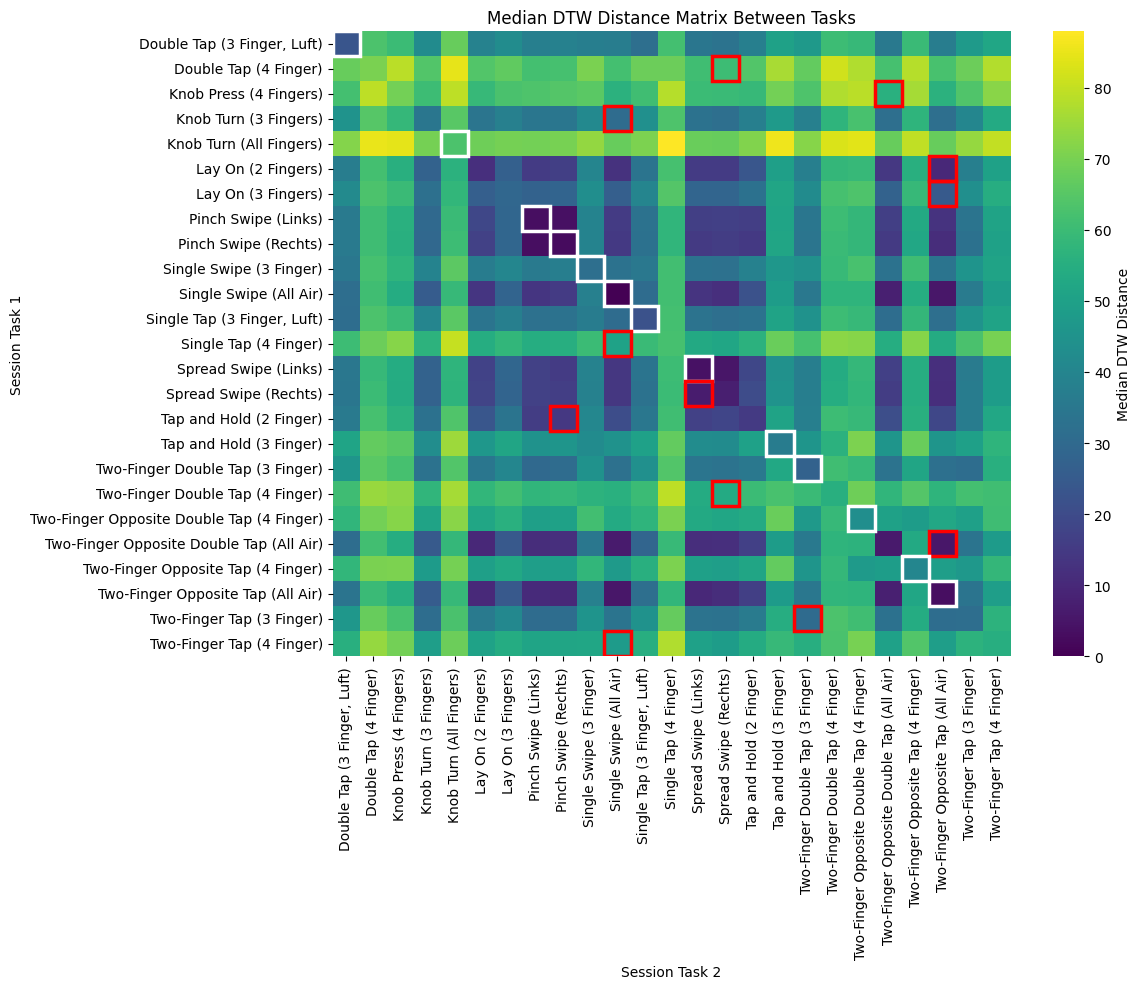

In [37]:
show_distances_heatmap(get_distance_df(['distance_0','distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_8','distance_8','distance_9',]))

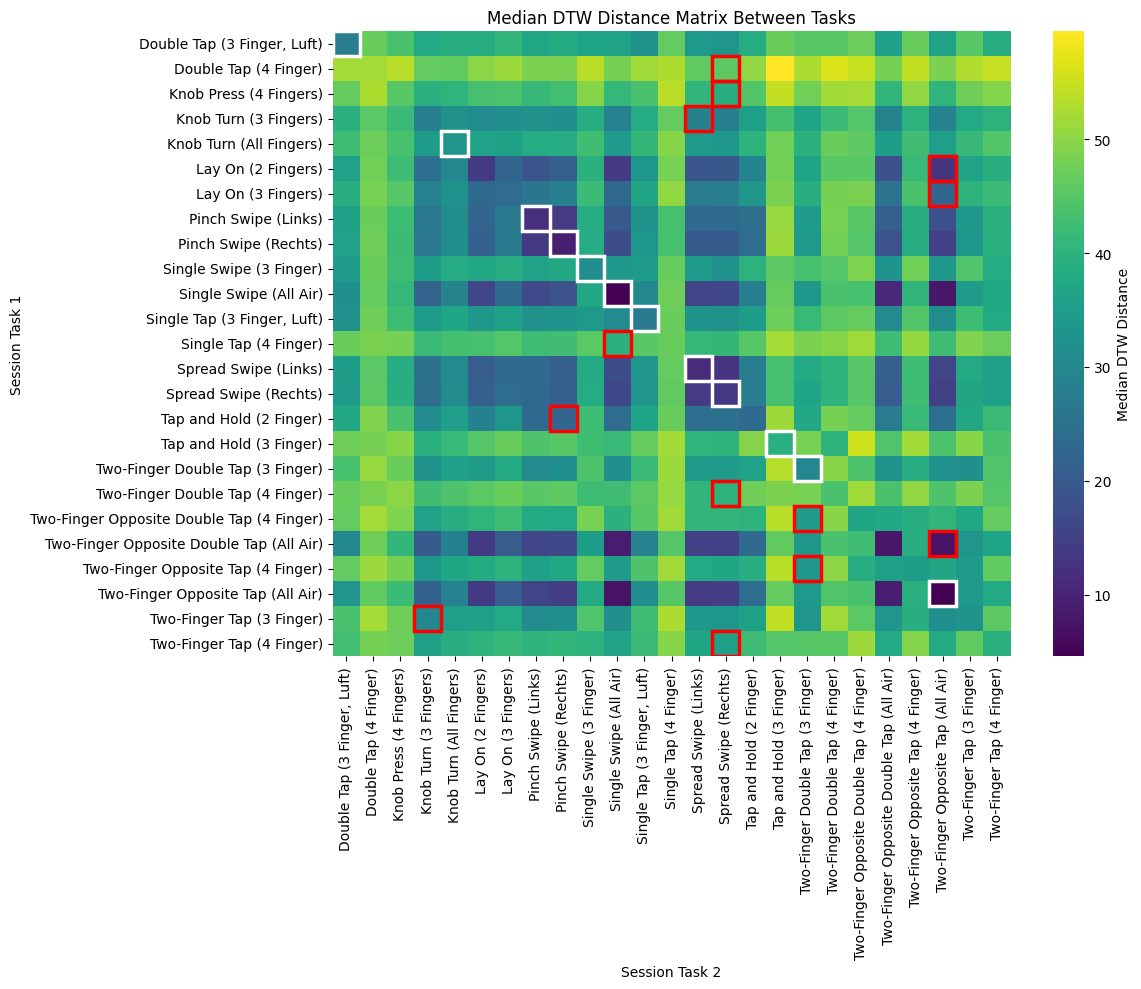

In [38]:
show_distances_heatmap(get_distance_df(['pressure', 'distance_0','distance_1']))

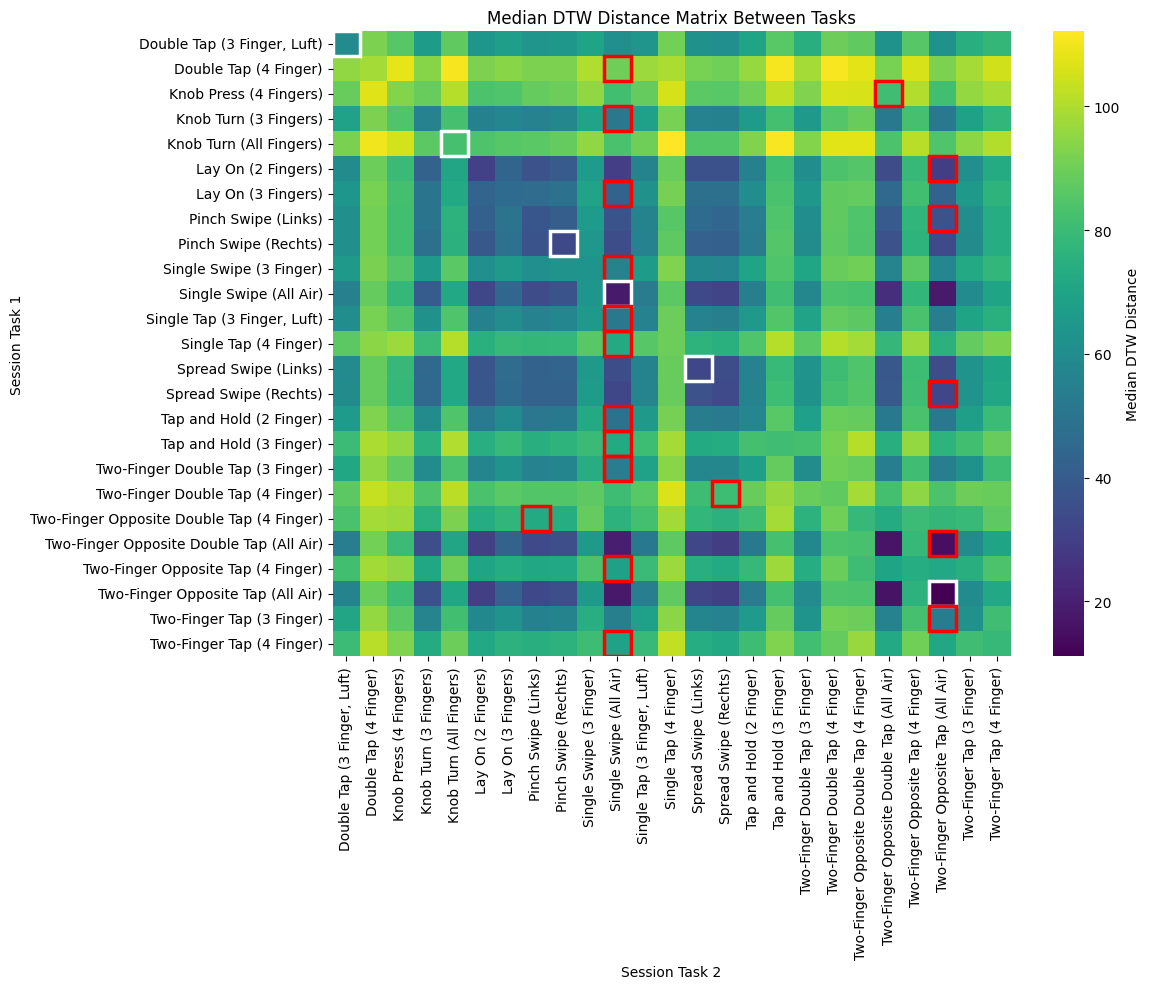

In [39]:
show_distances_heatmap(get_distance_df(['position_norm', 'pressure', 'channel', 'angular_velocity', 'angular_acceleration','distance_0','distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_8','distance_8','distance_9',]))

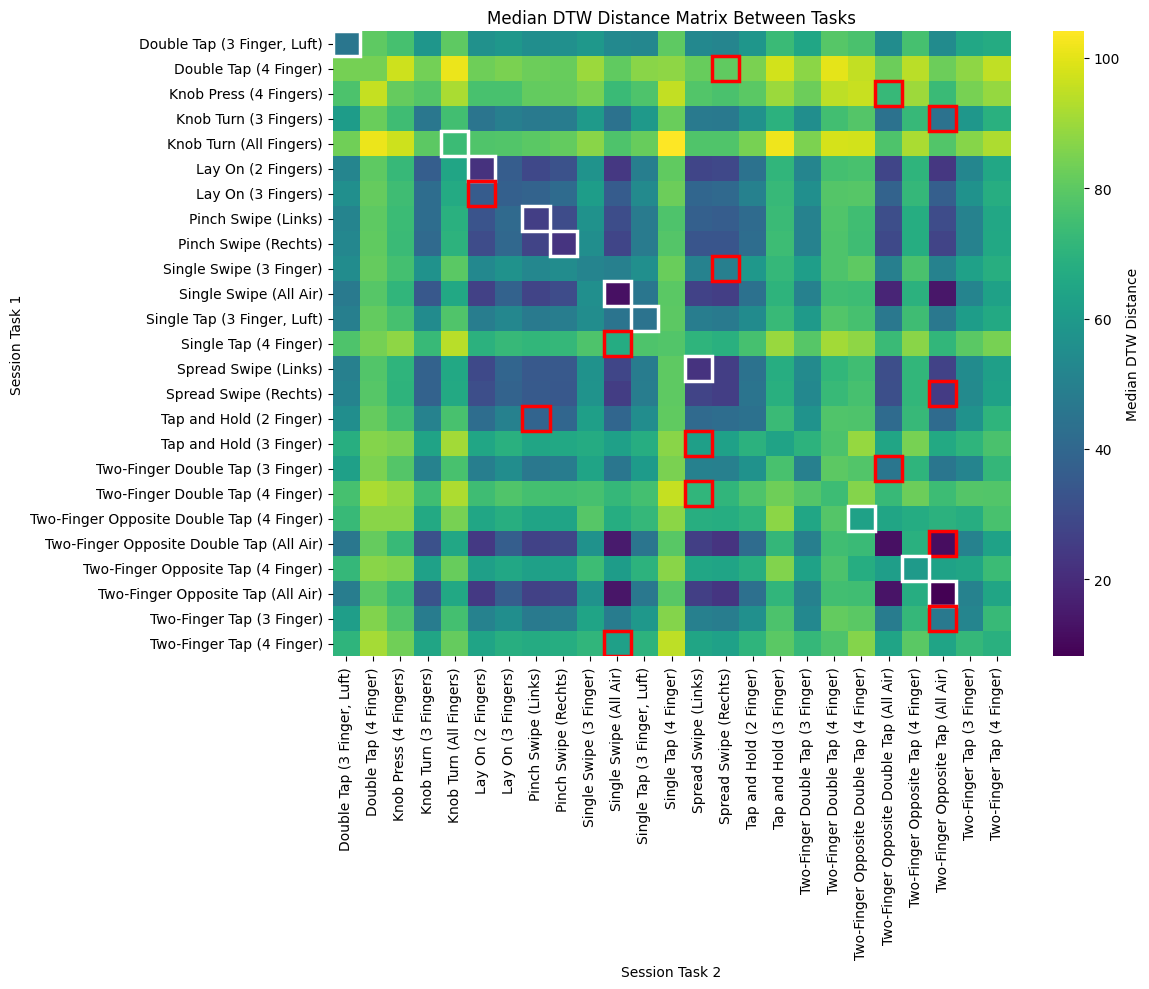

In [40]:
show_distances_heatmap(get_distance_df(['position_norm', 'pressure', 'channel', 'distance_0','distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_8','distance_8','distance_9',]))

In [41]:
distance_matrix, group_ids = get_distance_cluster(['position_norm', 'pressure', 'channel', 'angular_velocity', 'angular_acceleration','distance_0','distance_1','distance_2','distance_3','distance_4','distance_5','distance_6','distance_8','distance_8','distance_9'])

if np.isnan(distance_matrix).any() or np.isinf(distance_matrix).any():
    print("⚠️ Cleaning distance matrix (replacing NaN/inf with max finite value)...")
    finite_mask = np.isfinite(distance_matrix)
    max_finite = np.nanmax(distance_matrix[finite_mask])
    distance_matrix[~finite_mask] = max_finite

condensed_dist = squareform(distance_matrix, checks=False)

Z = linkage(condensed_dist, method='average')

C:\Users\joshu\AppData\Local\Temp\ipykernel_13620\266089364.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_gids)).colors


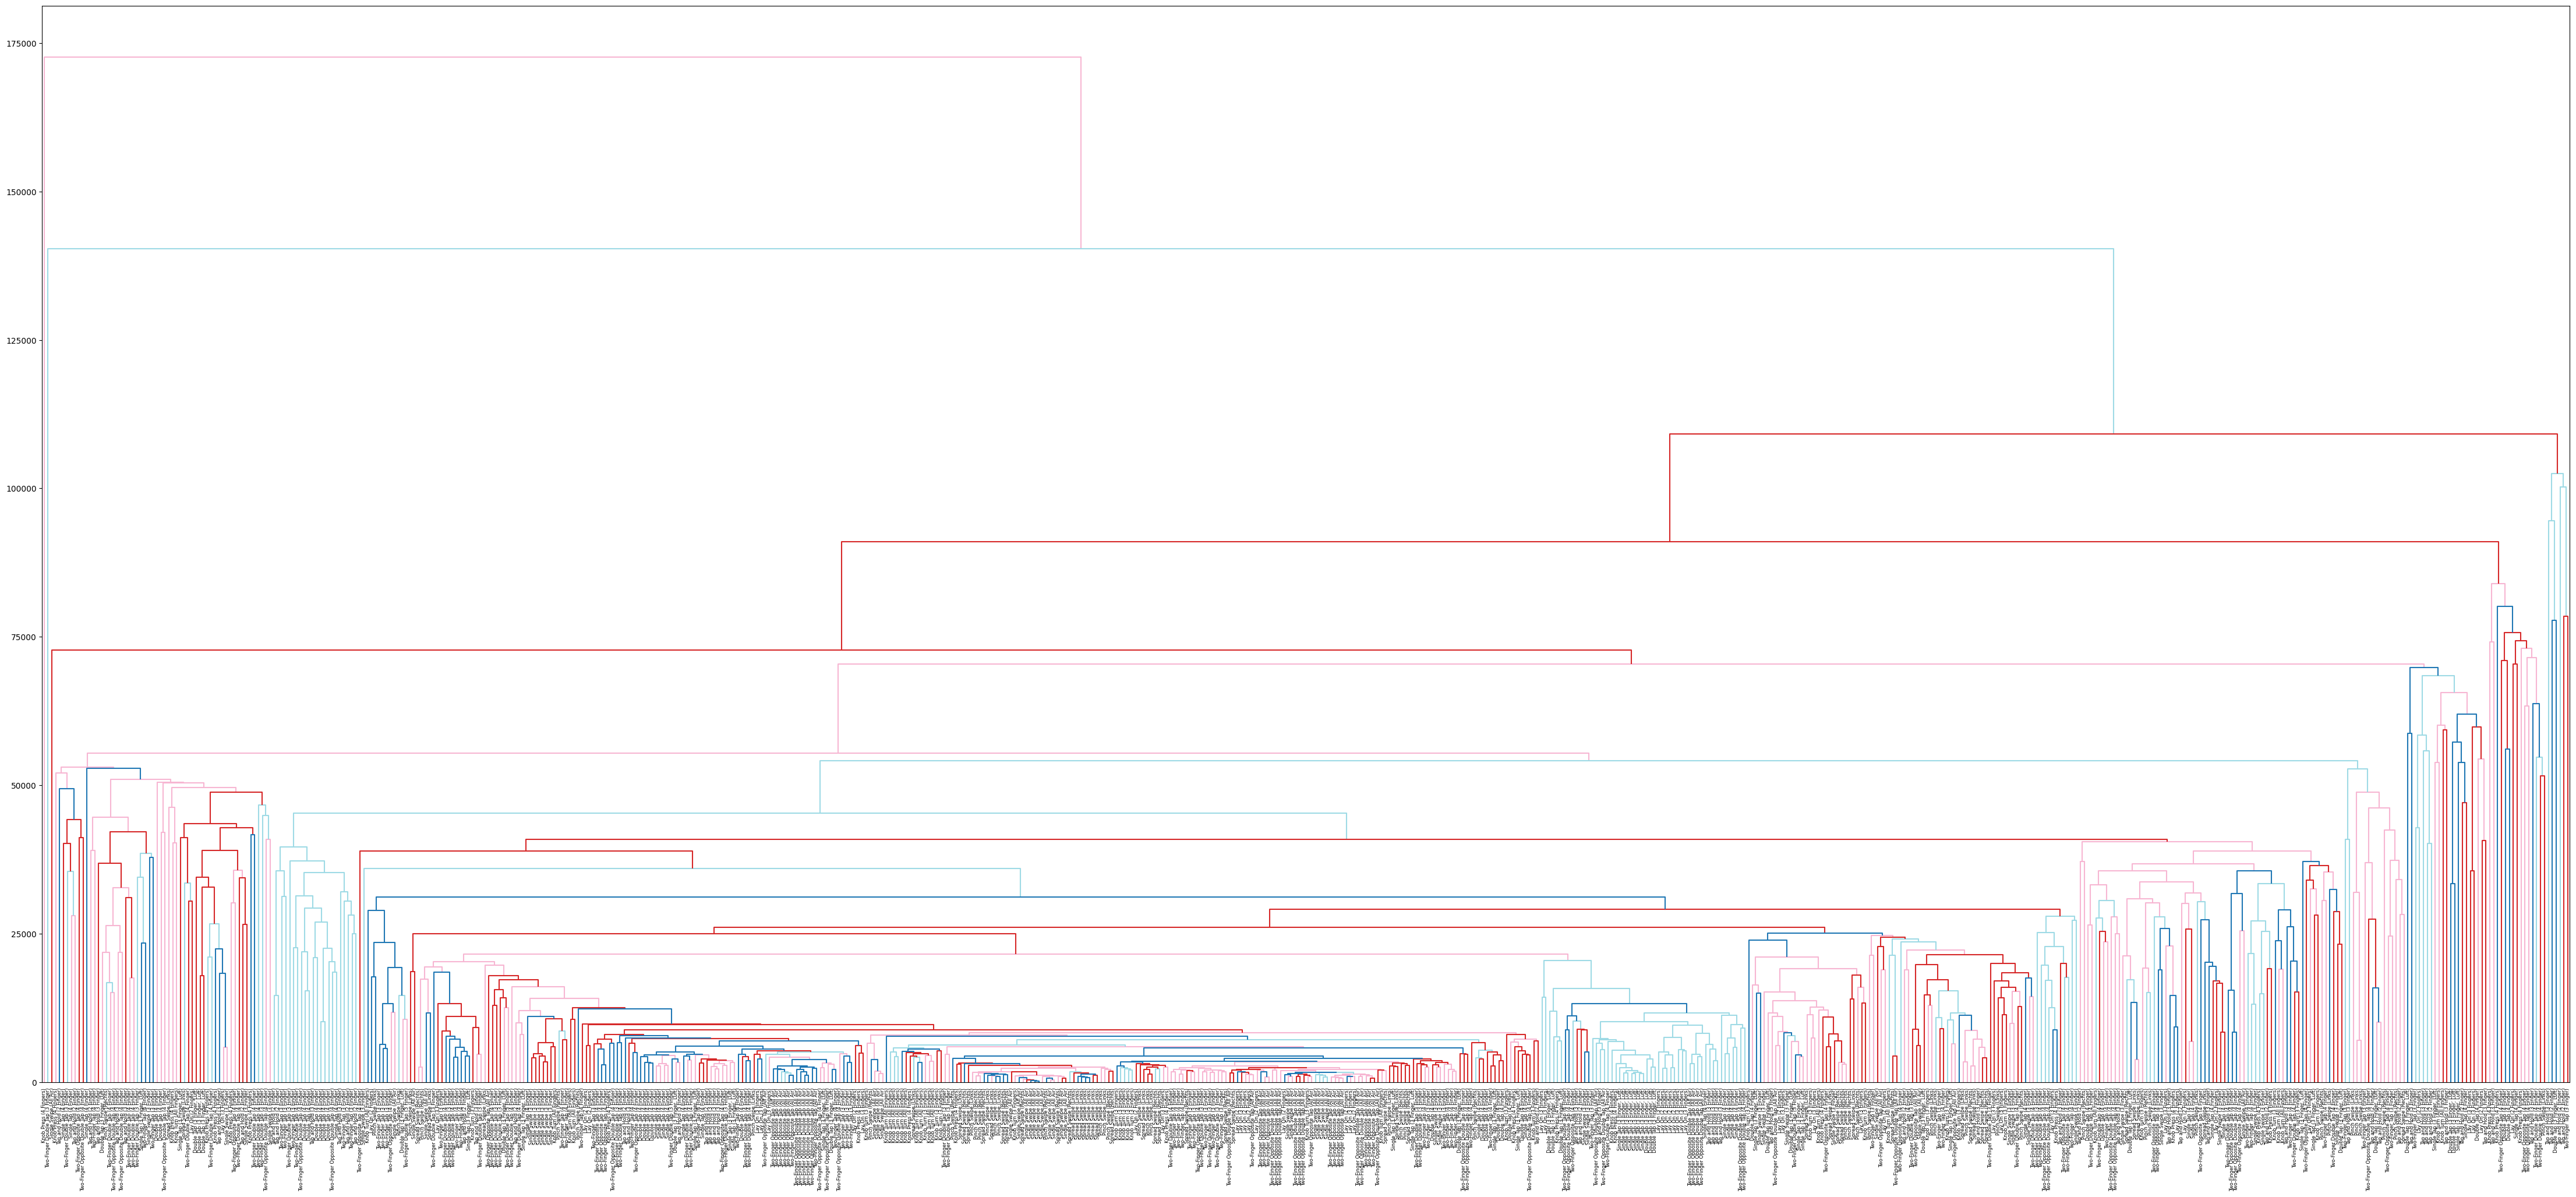

In [42]:
group_ids_only = [gid for gid, _ in group_ids]  # list of group_ids
unique_gids = sorted(set(group_ids_only))
N = len(group_ids_only)

# Create a colormap for group_ids
unique_gids = sorted(set(group_ids_only))
# Use a color palette with more distinct colors
colors = plt.cm.get_cmap('tab20', len(unique_gids)).colors
gid_to_color = {gid: colors[i % len(colors)] for i, gid in enumerate(unique_gids)}

# Map leaf index -> group_id
idx_to_gid = {i: gid for i, gid in enumerate(group_ids_only)}

def link_color_func(link_id):
    """
    Colors a branch by the group_id of the first leaf under it.
    """
    # In scipy 1.11+, dendrogram passes link_id = index in Z (0 to N+N-2)
    if link_id < N:
        # This is actually a leaf node
        gid = idx_to_gid[link_id]
    else:
        # Non-leaf node: link_id = N + i for Z[i]
        # Find the first leaf under this cluster using Z
        # We need access to Z here
        # We'll assume we have Z_global in scope
        leaves = get_leaves_under(link_id, Z_global, N)
        gid = idx_to_gid[leaves[0]]
    return mcolors.to_hex(gid_to_color[gid])

def get_leaves_under(node_id, Z, N):
    """
    Recursively find all leaf indices under a cluster node in Z.
    node_id: cluster id (leaf: 0..N-1, non-leaf: N..2N-2)
    """
    if node_id < N:
        return [node_id]
    else:
        # Non-leaf node: look in Z
        i = node_id - N
        left = int(Z[i, 0])
        right = int(Z[i, 1])
        return get_leaves_under(left, Z, N) + get_leaves_under(right, Z, N)

# Make Z_global accessible
Z_global = Z

plt.figure(figsize=(56, 24))
dendrogram(
    Z,
    labels=[task for gid, task in group_ids],
    leaf_rotation=90,
    leaf_font_size=6,
    link_color_func=link_color_func,
    color_threshold=0  # force all branches to use custom color
)
plt.show()

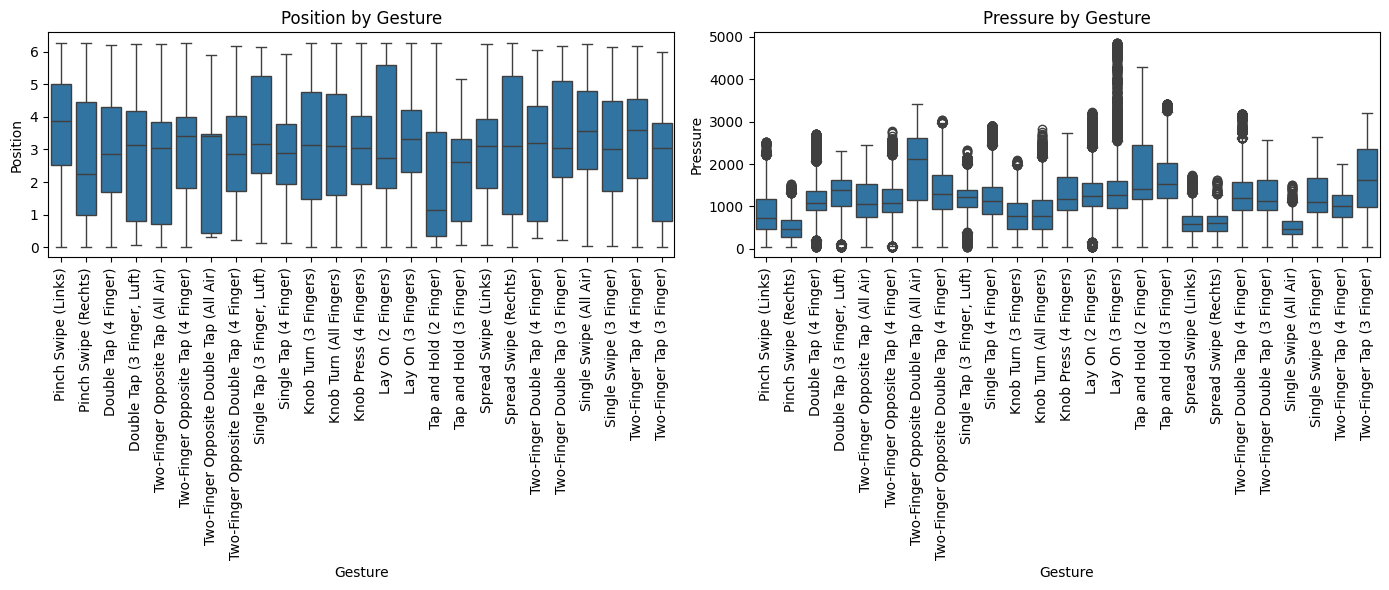

In [43]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for position per gesture
sns.boxplot(
    data=grouped_df,
    x="gesture",
    y="position",
    ax=axes[0]
)
axes[0].set_title("Position by Gesture")
axes[0].set_xlabel("Gesture")
axes[0].set_ylabel("Position")
axes[0].tick_params(axis='x', rotation=90)

# Boxplot for pressure per gesture
sns.boxplot(
    data=grouped_df,
    x="gesture",
    y="pressure",
    ax=axes[1]
)
axes[1].set_title("Pressure by Gesture")
axes[1].set_xlabel("Gesture")
axes[1].set_ylabel("Pressure")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
